In [1]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import memote
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


In [3]:
#Test the script on one CSV

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_250.csv')
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_750.csv')
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_1500.csv')
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_250.csv')
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_750.csv')

tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_1500.csv')




    


(5012, 697)
(5012, 686)
(5012, 1847)
(5012, 691)
(5012, 691)
(5012, 1855)


STAT NO. 2: Pairwise comparison of flux distributions
This offers a more comprehensive view on which reactions have a different flux distribution in between samples. The test used for this stat is the Kruskal-Wallis ranked test, which is a non-parametric test typically used for flux sampling to compare fluxes between groups

In [4]:
wt_250_750_sig, wt_250_750_non_sig =compare_flux_distributions(wt_250, wt_750, significance_threshold=0.001)
wt_250_1500_sig, wt_250_1500_non_sig =compare_flux_distributions(wt_250, wt_1500, significance_threshold=0.001)
wt_750_1500_sig, wt_750_1500_non_sig =compare_flux_distributions(wt_750, wt_1500, significance_threshold=0.001)


tr_250_750_sig, tr_250_750_non_sig = compare_flux_distributions(tr_250, tr_750, significance_threshold=0.001)
tr_750_1500_sig, tr_750_1500_non_sig = compare_flux_distributions(tr_750, tr_1500, significance_threshold=0.001)
tr_250_1500_sig, tr_250_1500_non_sig = compare_flux_distributions(tr_250, tr_1500, significance_threshold=0.001)

wt_tr_250_sig, wt_tr_250_non_sig = compare_flux_distributions(wt_250, tr_250, significance_threshold=0.001)
wt_tr_750_sig, wt_tr_750_non_sig = compare_flux_distributions(wt_750, tr_750, significance_threshold=0.001)
wt_tr_1500_sig, wt_tr_1500_non_sig = compare_flux_distributions(wt_1500, tr_1500, significance_threshold=0.001)

wt_invariant_fluxes = set(wt_250_750_non_sig) & set(wt_750_1500_non_sig)
#no invariant fluxes between all samples WT

tr_invariant_fluxes = set(tr_250_750_non_sig) & set(tr_750_1500_non_sig)
#0 invariant fluxes

wt_tr_250_750_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_750_non_sig)
#Only ATGS and CBMKs (Carbamate Kinase) as invariant fluxes detected
#Includes reactions directed towards Star

wt_tr_750_1500_invariant_fluxes = set(wt_tr_750_non_sig) & set(wt_tr_1500_non_sig)
#Only proline PD trannsport detected as invariant @ high conditions


wt_tr_250_1500_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_1500_non_sig)
#Invariant fluxes are related to photorespiratory export, interestingly enough. CO2 efflux from the Mitochondria, serine import and export from Mit. and Stroma

In [5]:
#Generation of Correlation Matrices 

wt_250_corr = wt_250.corr()
wt_750_corr = wt_750.corr()
wt_1500_corr = wt_1500.corr()

tr_250_corr = tr_250.corr()
tr_750_corr =  tr_750.corr()
tr_1500_corr = tr_1500.corr()

KeyboardInterrupt: 

In [6]:
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]
df_list = [wt_250, wt_750, wt_1500,tr_250, tr_750, tr_1500]

Generation of histograms and detailed analysis of Individual reactions at different light levels

These code blocks are for the analysis of the following reactions:
- Glycine Decarboxylase Activity
- Aminomethyltransferase Activity
- Correlation analysis for GLYDHDm for trans reactions (to identify which reactions are closely related to it then identify which contributes strongly to its reduction @ high levels)


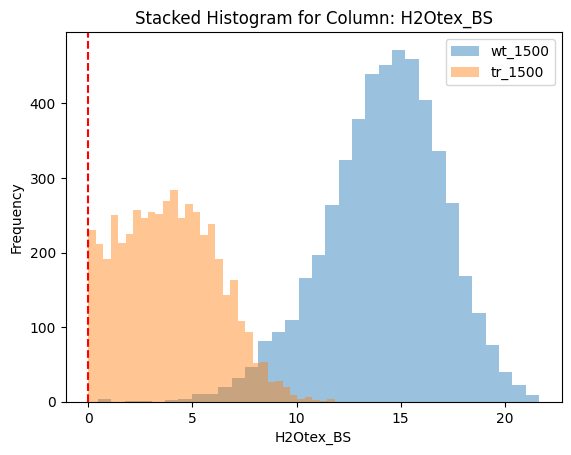

<Figure size 640x100 with 0 Axes>

In [53]:
generate_stacked_histogram(df_list, 'H2Otex_BS')

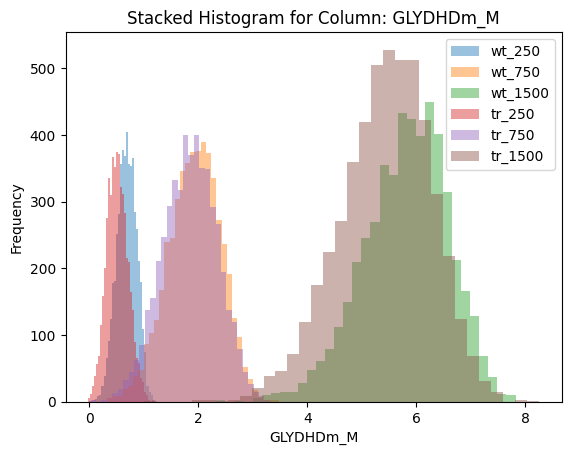

<Figure size 640x100 with 0 Axes>

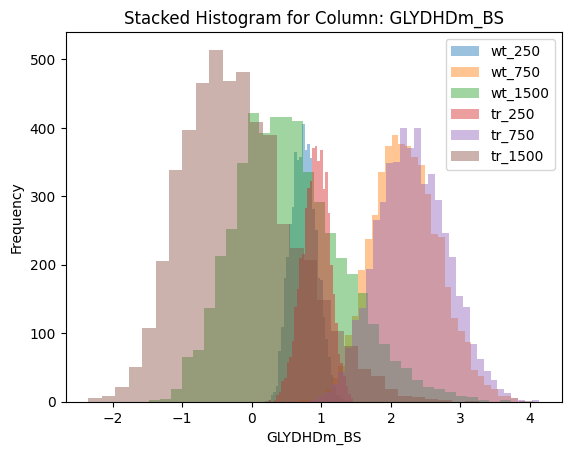

<Figure size 640x100 with 0 Axes>

In [47]:
#This is for Glycine Decarboxylase in the M cell. Behavior is increasing decarboxylation from lower to higher light levels. 
#The trans-parametrized reactions show modulation at high light levels. Why is that so?
#I can check the correlation matrix to see which reactions are 
generate_stacked_histogram(df_list, 'GLYDHDm_M')

generate_stacked_histogram(df_list, 'GLYDHDm_BS')



#Factors that may strongly affect Glycine decarboxylase activity (to check)
#Regeneration of Lipoylprotein (which is shown to have a direct correlation with Glycine Decarboxylase activity. (1.00 CCorr)
#Serine plasmodesmatal export (1.0 corr)
#Glycine Decarboxylase activity in the other compartment (
#Serine Hydroxymethyltransferase (production of Serine via transhydroxymethylation from MethyleneTHF (1.00 Corr)


- NH4 transport to the Mitochondria (which in turn is linked towards the C2 cycle via the Aminomethyltransferase reaction) (0.950757 corr coef)

Findings:
- Glycine Decarboxylase is modulated in the trans-parametrized models without explicit constraints, showing a lower reaction flux in the M comnpartment compared to the BS comparement.
- Reaction becomes decoupled only at high light while  showing close distributions at low to medium light levels -- although the KW test reports significant differences in the distribution between the two parametizations @ 95% confidence interval. I'll check with 99.99% interval instead
    - It is coupled in low and medium lights and only diverges @ high light treatments. 
- The most likely culprit for the decrease in Gly DC activity in M cells is the increase in flux of NH4 to BS cell Mit. However, it does not correspond with an increase in GLyDH activity in the BS cell meaning that it is being used up in other reactions. Other reactions that were found to increase is the import of Serine into the M cell which is @ equilibrium but slightly skewed towards BS cell export in the Trans model.


Question: 
- Is dihydrolipoylprotein:NAD+ oxidoreductase skewed towards NAD+ reduction or Oxidation? -- (It is towards regeneration of NADH) in both WT and TR.
- Therefore, is the reduction in glycine flux attributable to other reactions that reduce the NADH pool? Let's check all the reactions that make use of NADH in the M compartment.
- Based on the below plots, only Malate Dehydrogenase has a significantly varying distribution compared to the other reactions that involve NADH. The Trans model shows significantly lowered flux toward the oxidation of Malate and in turn the regeneration of NADH. The other reaction is the NADORm_M reaction, which corresponds to the NADH-coenzyme Q oxidoreductase reaction that consumes NADH to produce ubiquinol.

- These are the most likely culprits behind the reduced flux towards the GlyDC reaction as reduction of flux towards  Malate Dehydrogenase reaction reduces the Mitochondria. The **NADOR** reaction also consumes NADH to reduce Ubiquinone and has quite a high flux towards consumption of NADH.

Another question:
- Why is demand for q8h2 so high in the trans model? Let's check the reactions involving this metabolite.
    - Results show that the reaction CYOR (Cytochrome Oxidoreductase) has a significantly higher flux in TR than in WT. What does it mean?
    - I haven't modified this reaction so it has a significantly high imbalance (which I think is similar to other models)
    - Both Coenzyme Q and Cytochrome Oxidoreductase are significantly higher in high light conditions. How about in low and medium light conditions?
    
        - Only in high light conditions is this true. Meaning that the cytochrome fluxes are significantly higher in the Trans parametrized model for some reason, not sure why.
        I need to review literature on this, particularly this:
            "Mitochondria in photosynthetic cells: Coordinating redox control and energy balance" 
        Since the involved reactions are part of the ETC.
        
        I think this is also related towards the mitochondrial production of Citrate via CSm since it is also significantly upregulated in the Trans compared to the WT. This I think shows evidence of a significantly higher percent of photoassimilates being diverted to the Citric Acid Cycle. However, is it for the purpose of exporting citrate to the cytosol?
            - It is and it is equal to the amount of flux towards the Citrate Synthase, meaning that the flux towards the TCA cycle is hemicyclic and is for generating Redox potential in the Cytosol (Igamberdiev & Bykova, 2023). This may indicate a deficit in redox units in the Cytosol which necessitate its synthesis and export.
            - Increase in Malate dehydrogenase carrying capacity in Trans model may be observed to cause this change, which also drives the efflux of Citrate  and the importation of Malate.
        
        
        
Things to check:

- Check if GOGAT enzymes are increased to compensate for NH3 increase due to higher 
        
Interesting!

What does this mean, though?

June 17, 2023:
It seems that there is internal cycling in my reactions. I've cross validated my samples with the Flux results that I have obtained via pFBA -> Loopless sol'n and found that the fluxes particularly for mitochondrial metabolism are quite inflated

1. Check reactions involving NADH in mitochondria in M cell
Interesting things to note:
- THD2c_M (NADP transhydrogenase) is suppressed in the Trans model except at high light concentrations, possibly indicating low NADH supply in the mitochondrial compartment at low-high light conditions, while it is found to be active at all light points in the WT model
- Malate dehydrogenase has significantly high fluxes in the Trans model but is generally lower than the prescribed upper bound (which is at the range of 140 umol/m2s).
- Significantly high fluxes towards the mETC are seen


In [10]:
wt_model.reactions.ICHDxm_M

<Reaction ICHDxm_M at 0x7f079bc838e0>

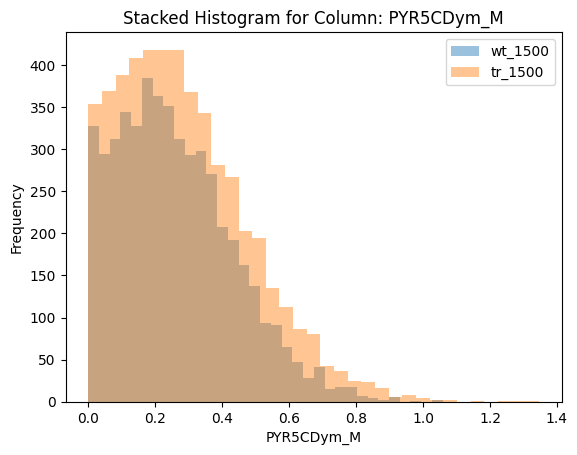

<Figure size 640x100 with 0 Axes>

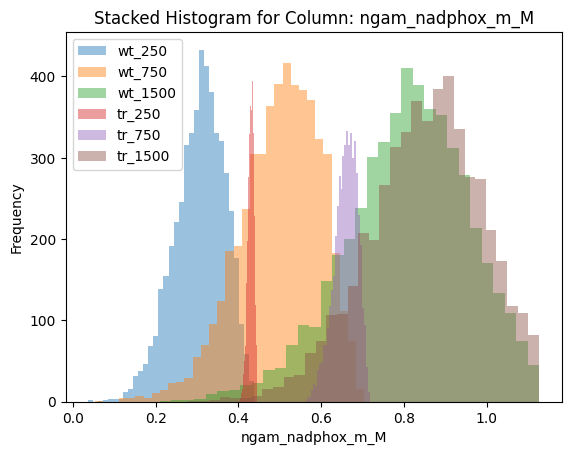

<Figure size 640x100 with 0 Axes>

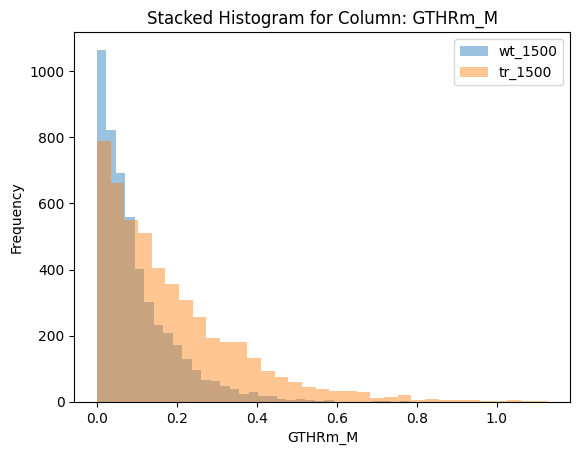

<Figure size 640x100 with 0 Axes>

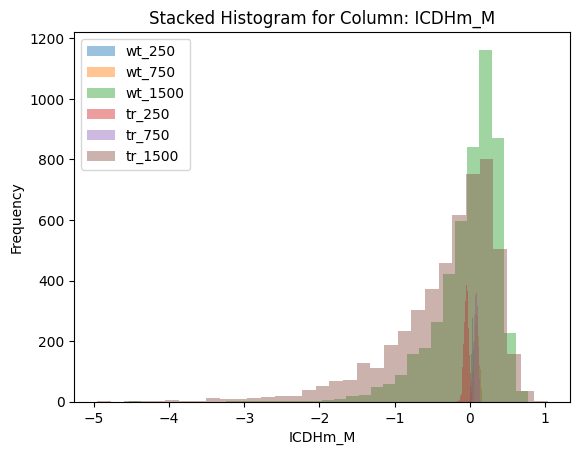

<Figure size 640x100 with 0 Axes>

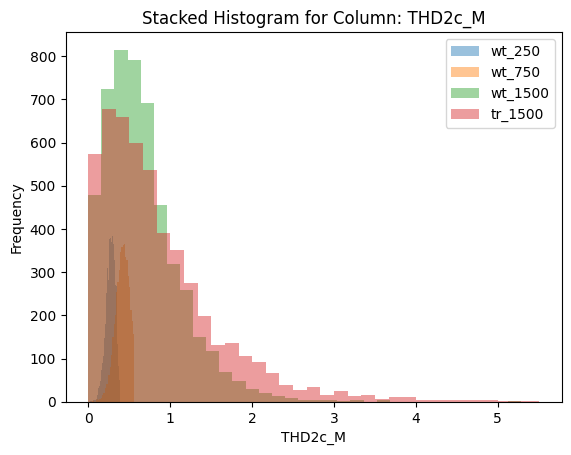

<Figure size 640x100 with 0 Axes>

In [48]:


#Reactions involving NADPH in the Mitochondria M cell
for nadph_rxns in wt_model.metabolites.nadph_m0.reactions:
    nadph_rxn_id = nadph_rxns.id
    check = check_column_exists(df_list, nadph_rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, nadph_rxn_id)


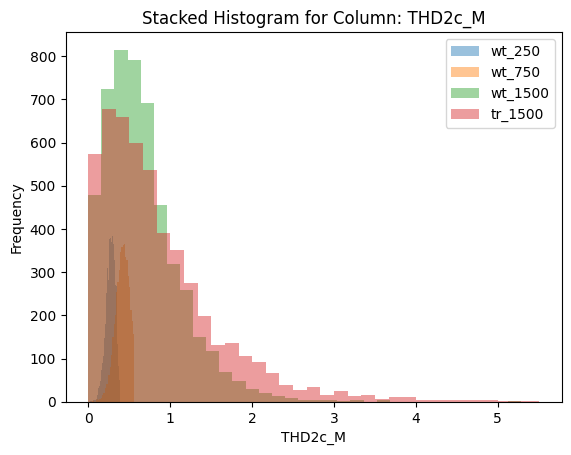

<Figure size 640x100 with 0 Axes>

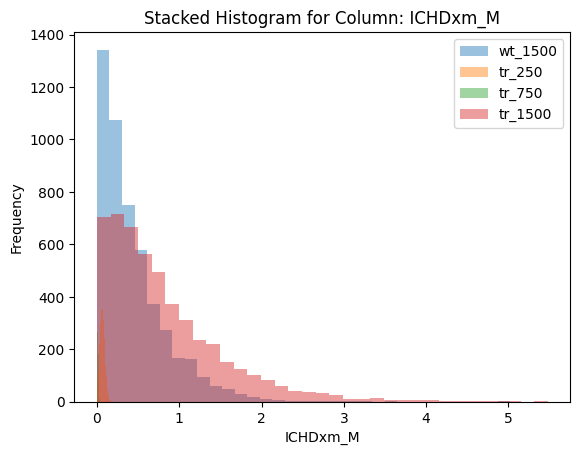

<Figure size 640x100 with 0 Axes>

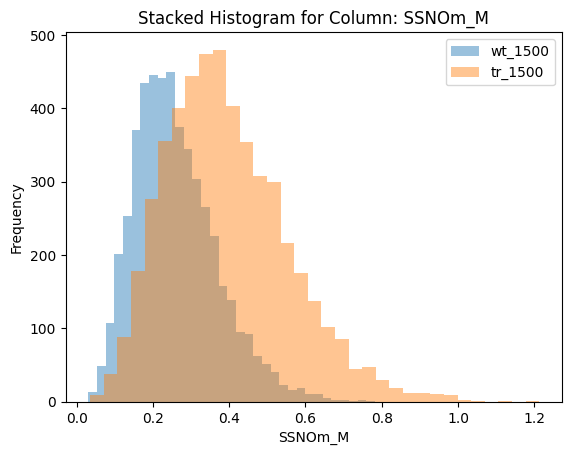

<Figure size 640x100 with 0 Axes>

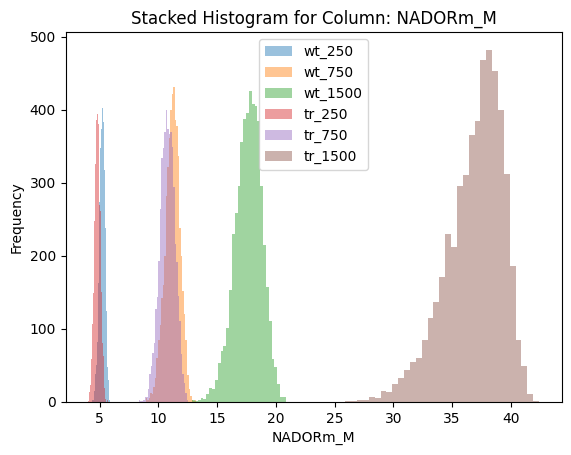

<Figure size 640x100 with 0 Axes>

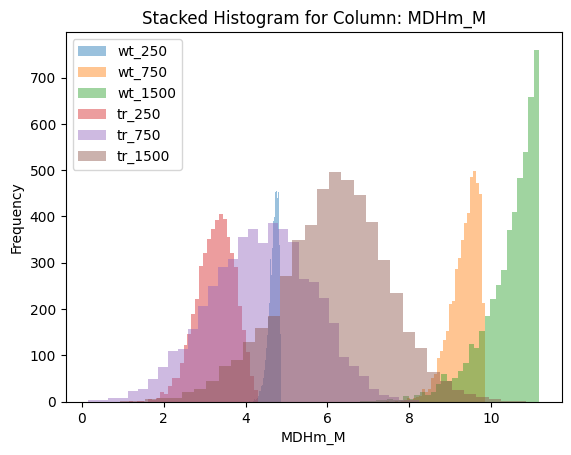

<Figure size 640x100 with 0 Axes>

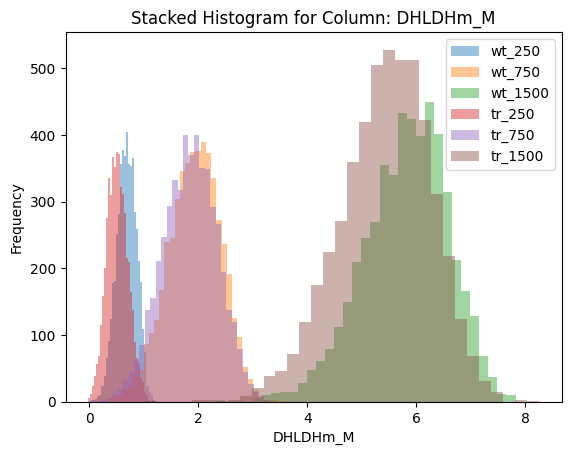

<Figure size 640x100 with 0 Axes>

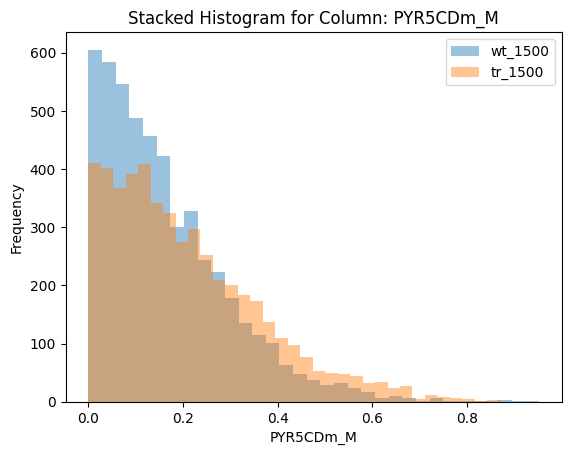

<Figure size 640x100 with 0 Axes>

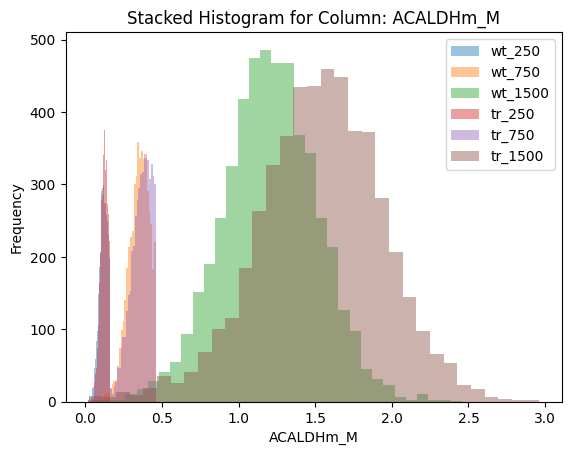

<Figure size 640x100 with 0 Axes>

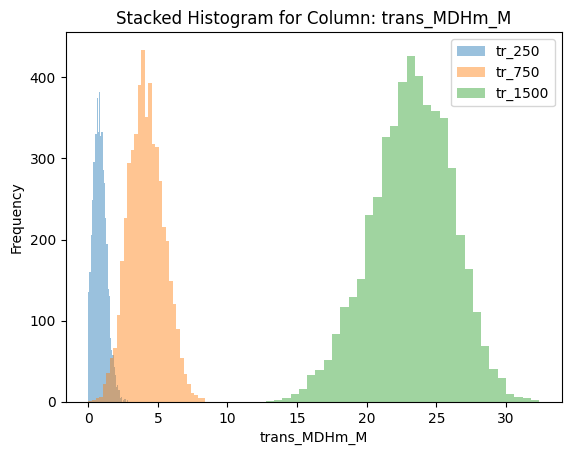

<Figure size 640x100 with 0 Axes>

In [8]:


#Reactions involving NADH in the Mitochondria M cell
for nadh_rxns in wt_model.metabolites.nadh_m0.reactions:
    nadh_rxn_id = nadh_rxns.id
    check = check_column_exists(df_list, nadh_rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, nadh_rxn_id)

generate_stacked_histogram(df_list, 'trans_MDHm_M')

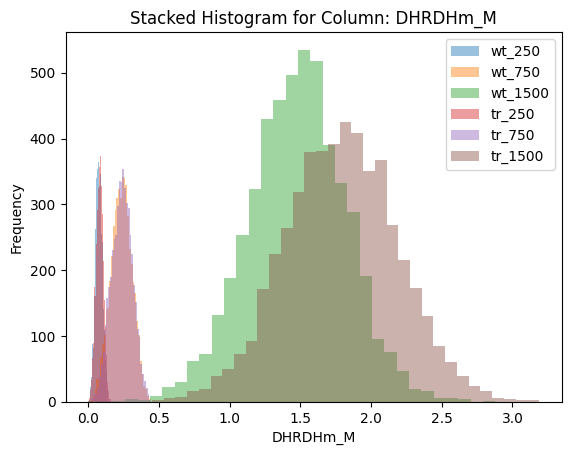

<Figure size 640x100 with 0 Axes>

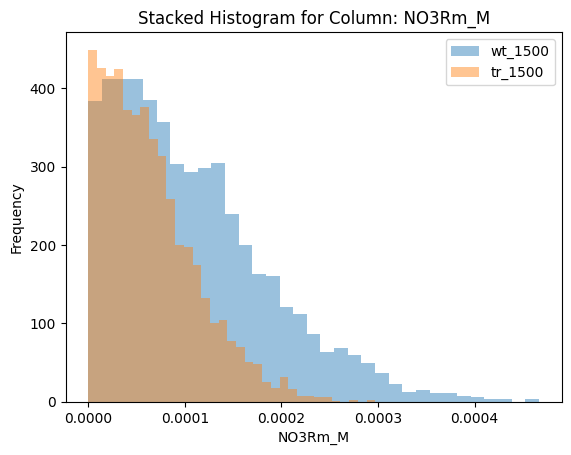

<Figure size 640x100 with 0 Axes>

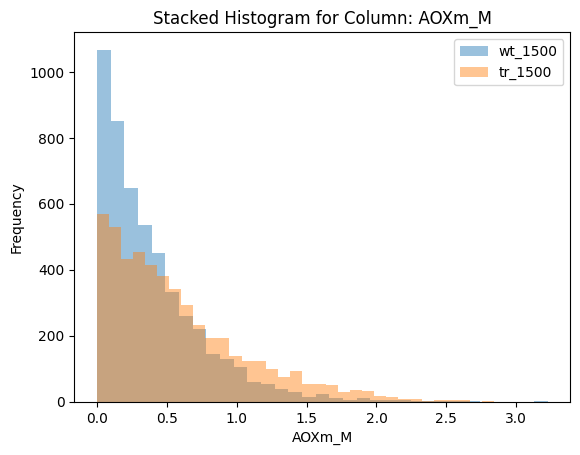

<Figure size 640x100 with 0 Axes>

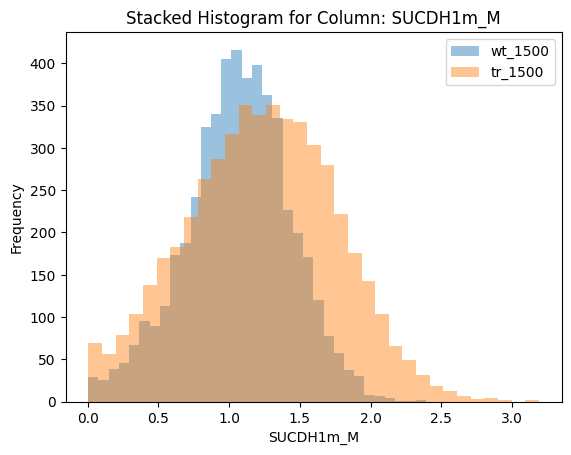

<Figure size 640x100 with 0 Axes>

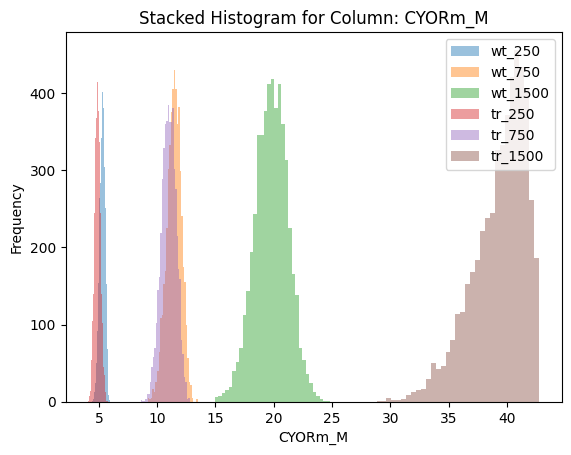

<Figure size 640x100 with 0 Axes>

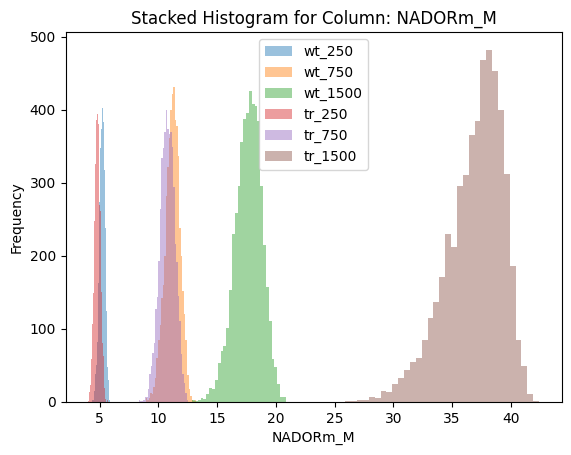

<Figure size 640x100 with 0 Axes>

In [11]:
#Reactions involving ubiquinol in the cell



#Reactions involving ubiquinol in the Mitochondria M cell
for q8h2_rxns in wt_model.metabolites.q8h2_m0.reactions:
    rxn_id = q8h2_rxns.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)


In [16]:
wt_model.reactions.get_by_id('SUCL(ADP)m_M')

<Reaction SUCL(ADP)m_M at 0x7f079bd6fa60>

2. Analysis of TCA cycle
Citrate -> Isocitrate -> AKG -> Succ-CoA -> Succ -> Fum -> Mal -> OAA -> Cit

Which reactions are reversed?

Citrate to OAA is active in cytosol (ATPCSc) meaning that Citrate is exported out of Mit and converted to OAA. Is it converted to Malate? 
It is converted to Malate by Cytosolic Malate Dehydrogenase. Afterwards it is transported to the Mit via the MalCit valve. Only that is active rather than the MAL-AKG valve

AKG dehydrogenase is inactive and therefore the complete Krebs cycle is not active, only its hemicylic form

Fum -> Mal active at High light only

Icit <-> AKG centered at 0 in all light levels (in equilibrium)

What happens to the AKG? 


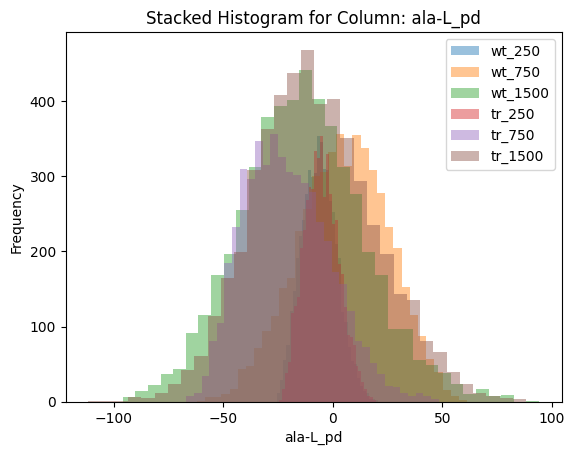

<Figure size 640x100 with 0 Axes>

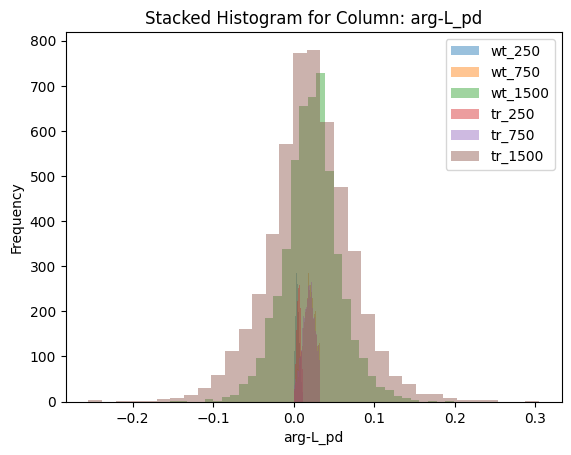

<Figure size 640x100 with 0 Axes>

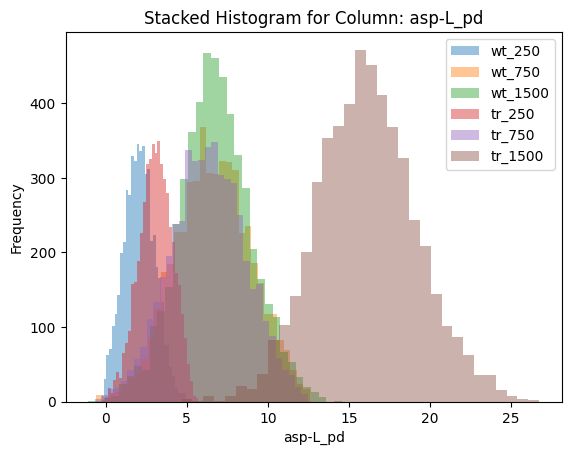

<Figure size 640x100 with 0 Axes>

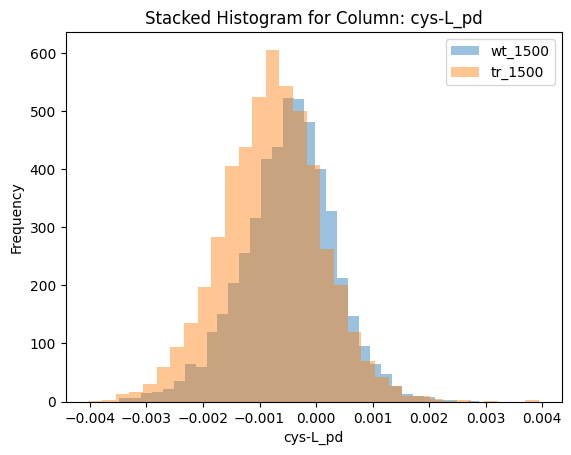

<Figure size 640x100 with 0 Axes>

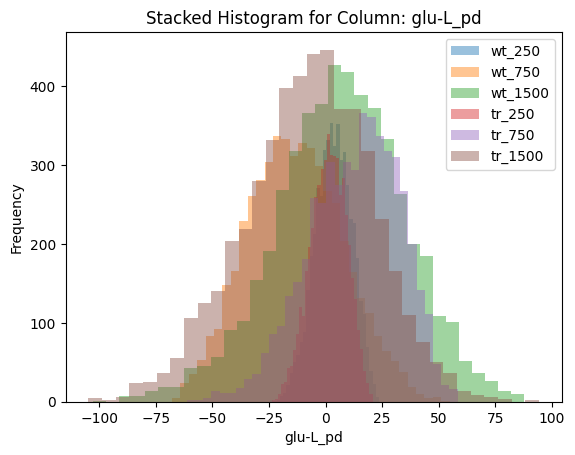

<Figure size 640x100 with 0 Axes>

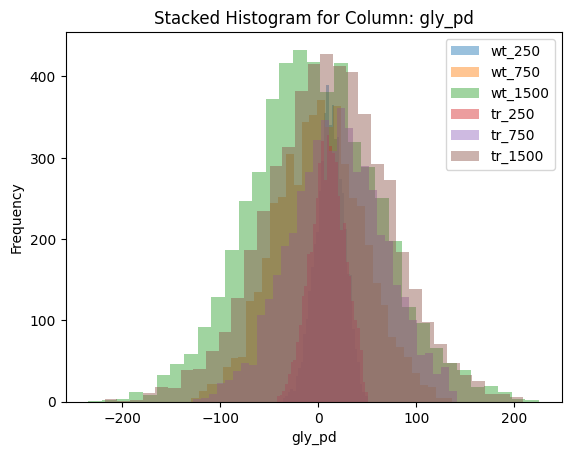

<Figure size 640x100 with 0 Axes>

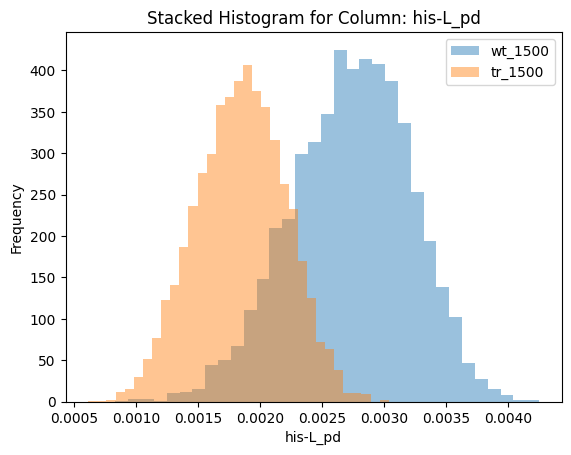

<Figure size 640x100 with 0 Axes>

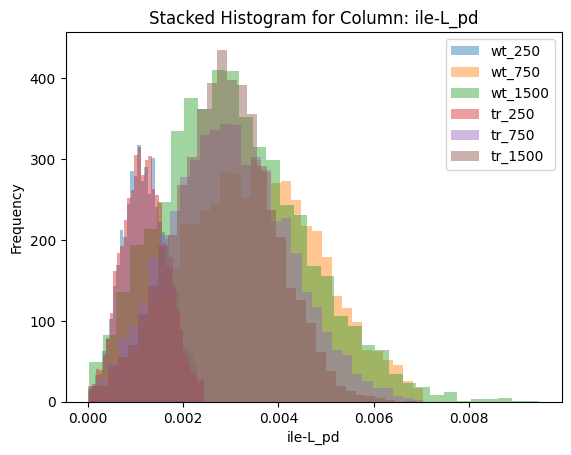

<Figure size 640x100 with 0 Axes>

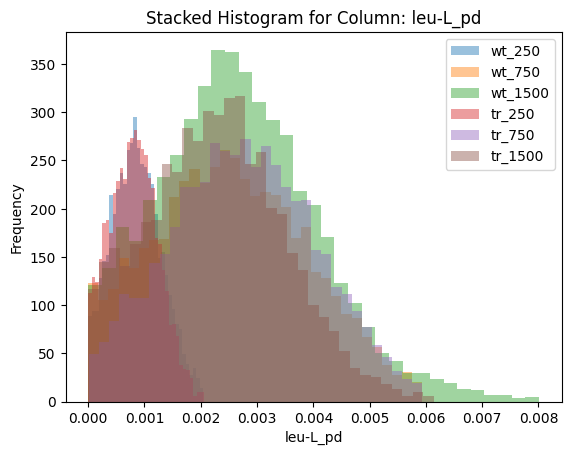

<Figure size 640x100 with 0 Axes>

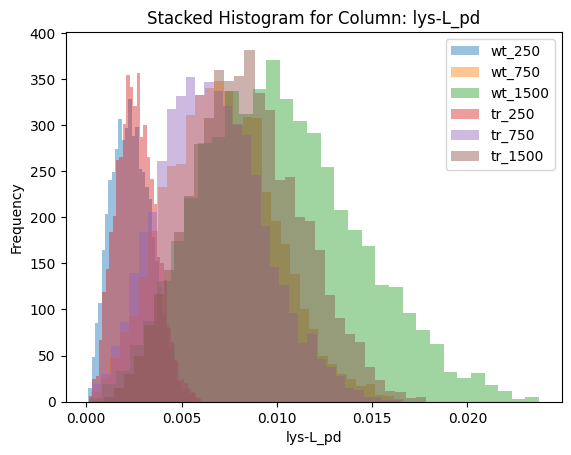

<Figure size 640x100 with 0 Axes>

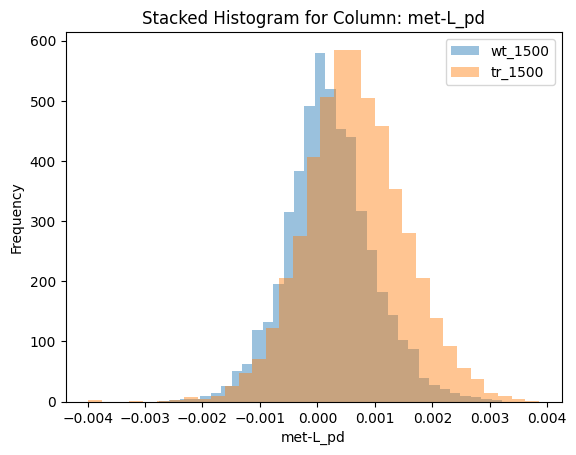

<Figure size 640x100 with 0 Axes>

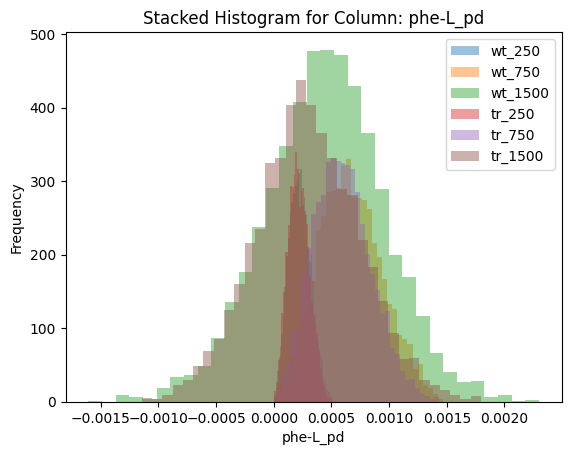

<Figure size 640x100 with 0 Axes>

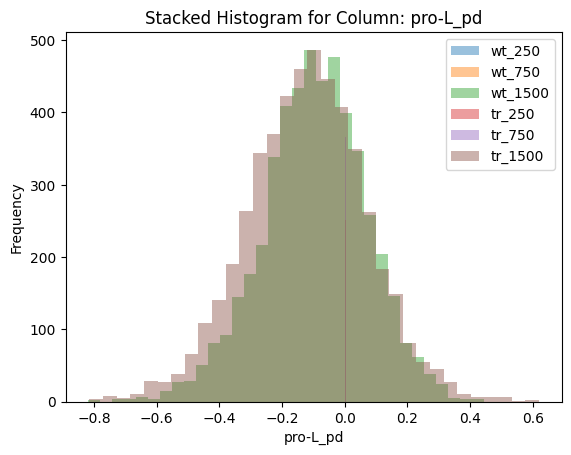

<Figure size 640x100 with 0 Axes>

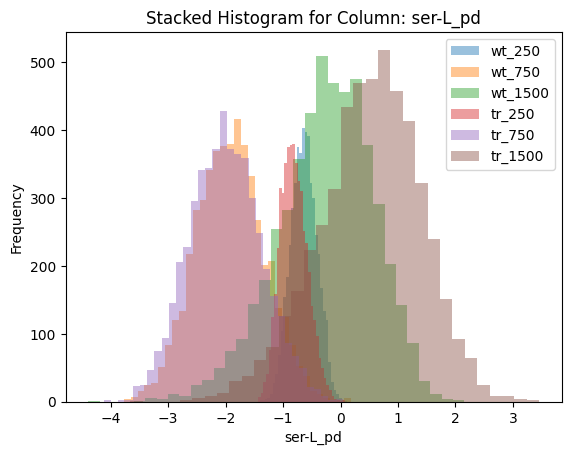

<Figure size 640x100 with 0 Axes>

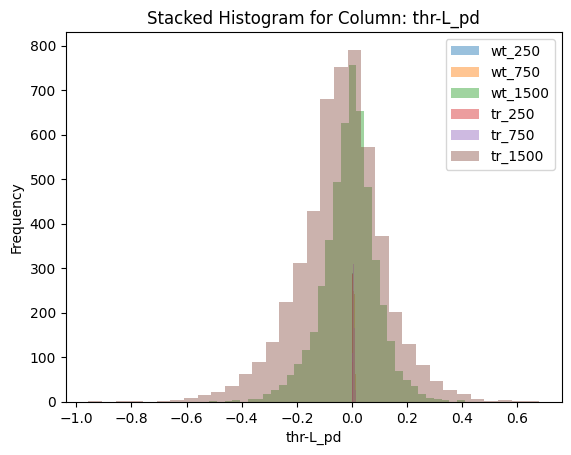

<Figure size 640x100 with 0 Axes>

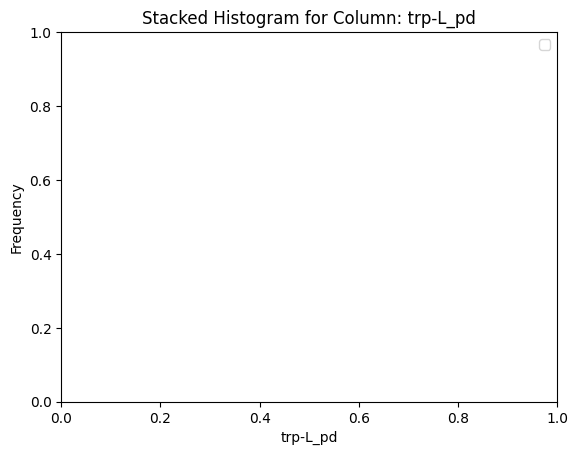

<Figure size 640x100 with 0 Axes>

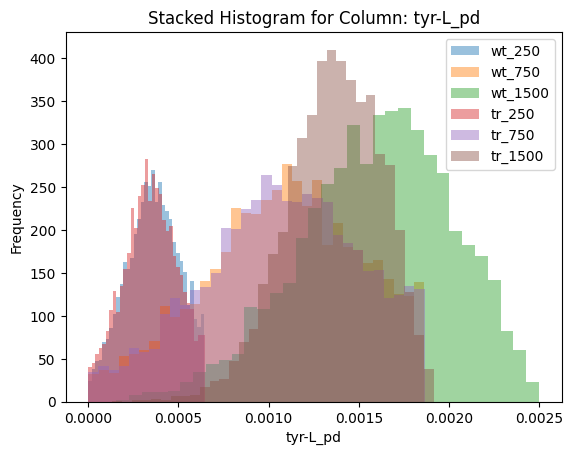

<Figure size 640x100 with 0 Axes>

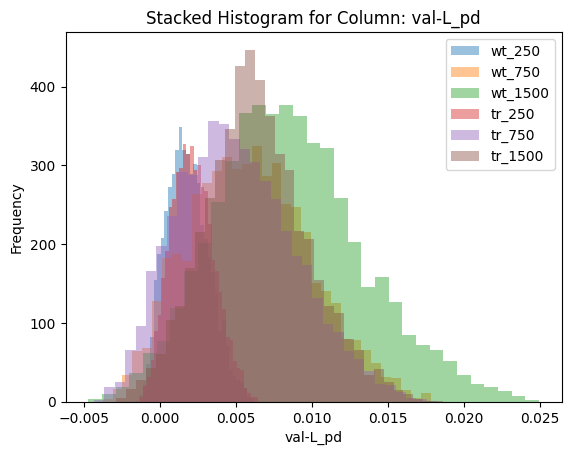

<Figure size 640x100 with 0 Axes>

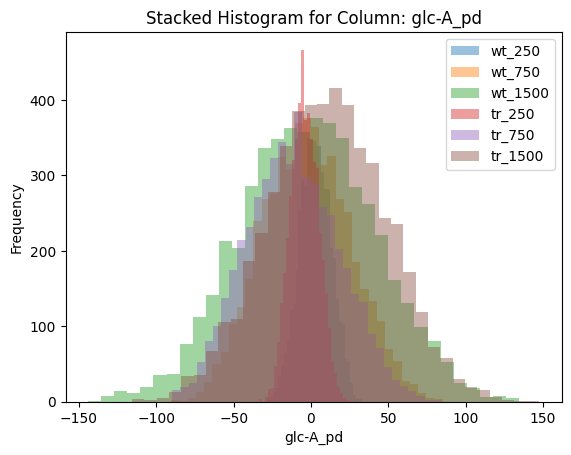

<Figure size 640x100 with 0 Axes>

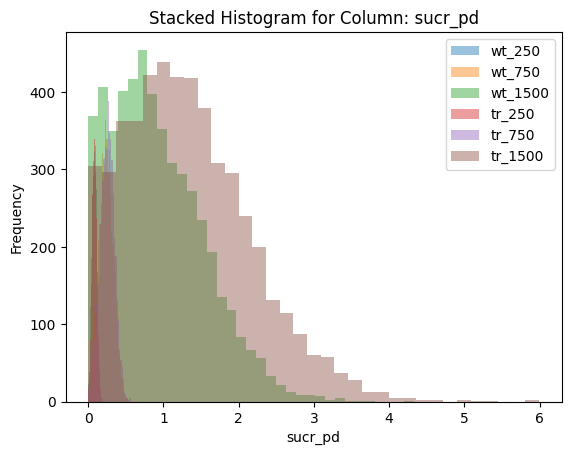

<Figure size 640x100 with 0 Axes>

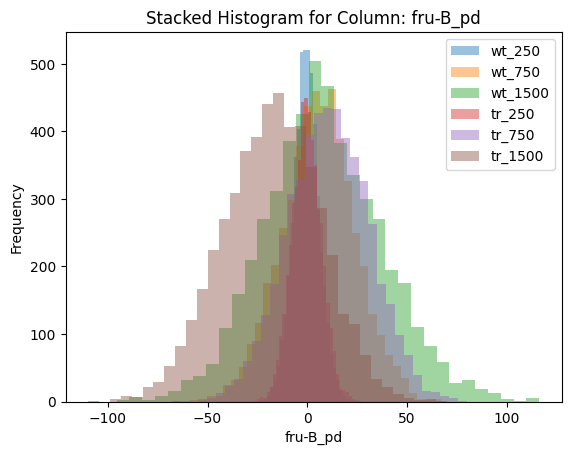

<Figure size 640x100 with 0 Axes>

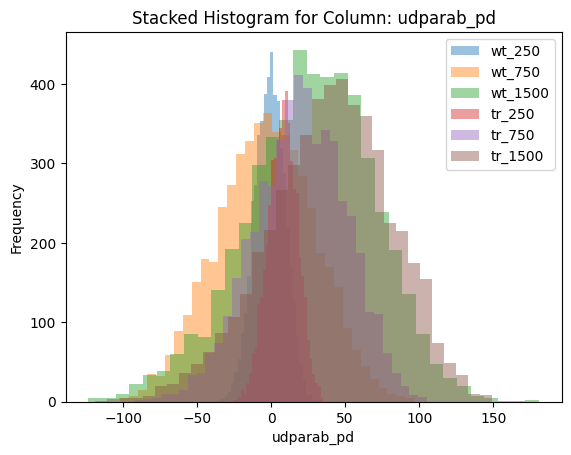

<Figure size 640x100 with 0 Axes>

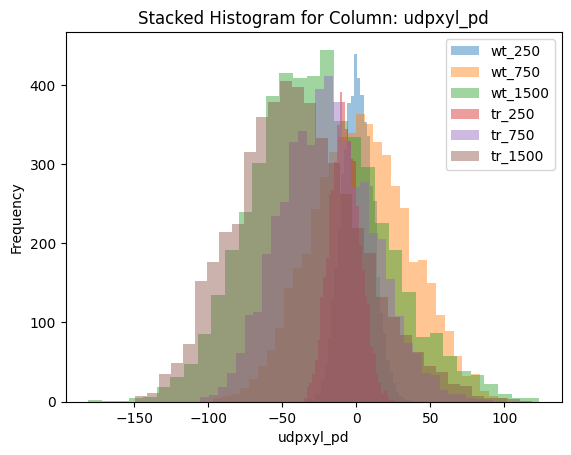

<Figure size 640x100 with 0 Axes>

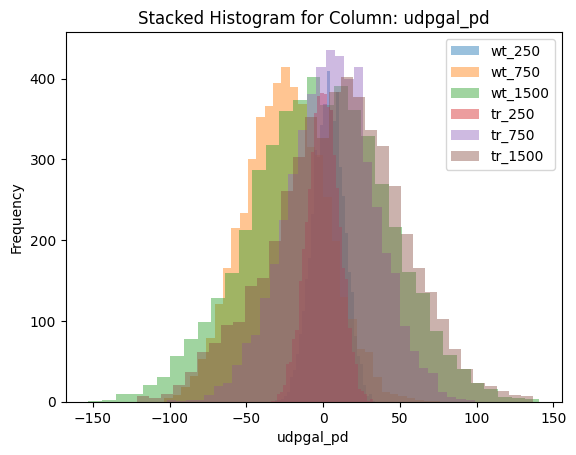

<Figure size 640x100 with 0 Axes>

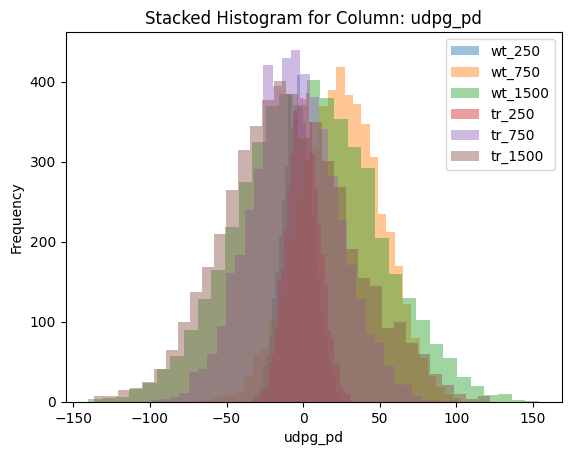

<Figure size 640x100 with 0 Axes>

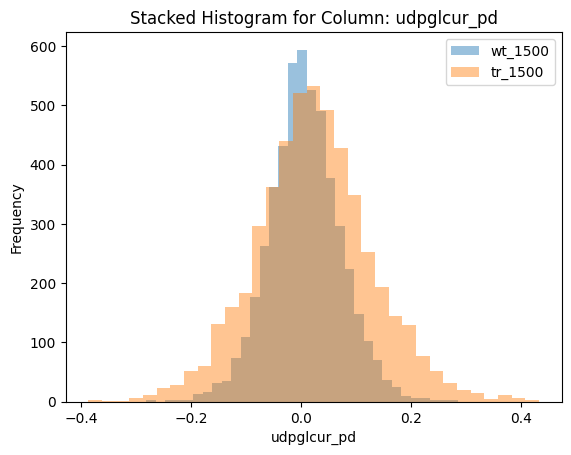

<Figure size 640x100 with 0 Axes>

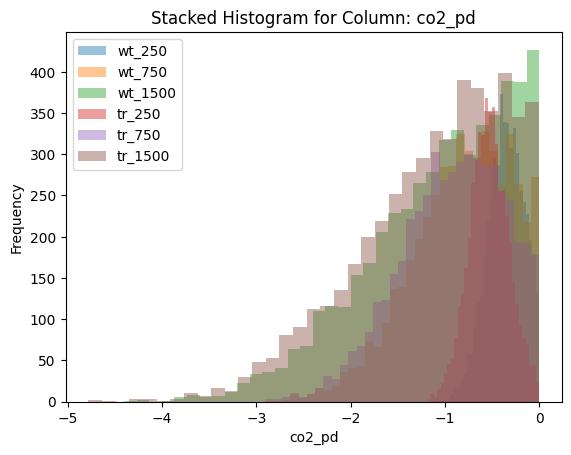

<Figure size 640x100 with 0 Axes>

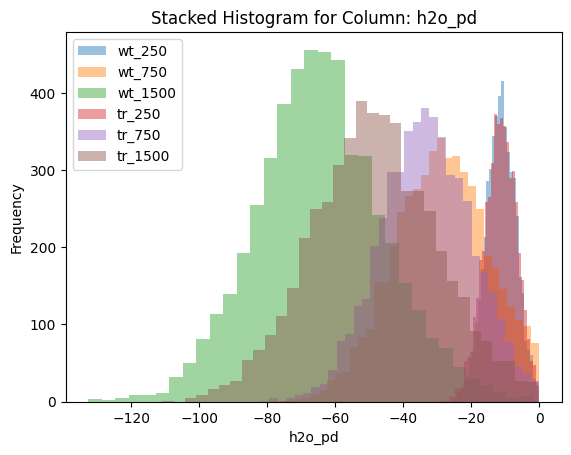

<Figure size 640x100 with 0 Axes>

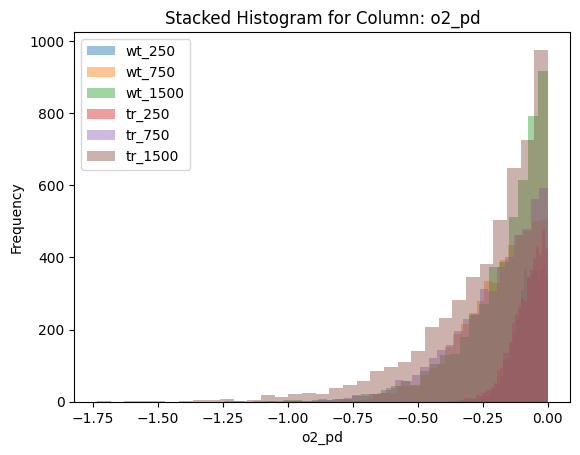

<Figure size 640x100 with 0 Axes>

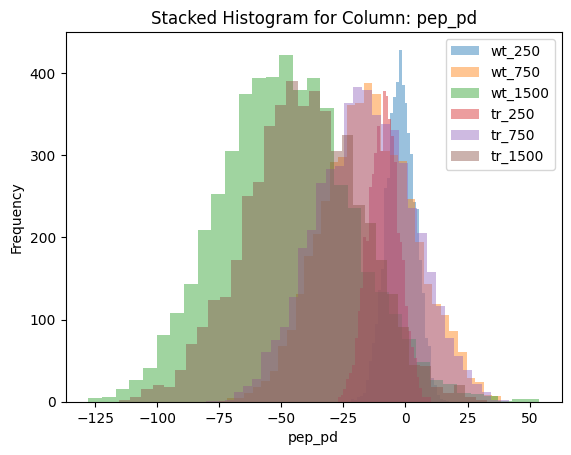

<Figure size 640x100 with 0 Axes>

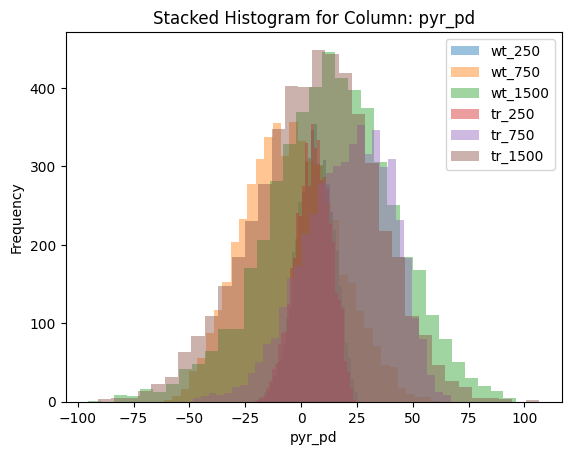

<Figure size 640x100 with 0 Axes>

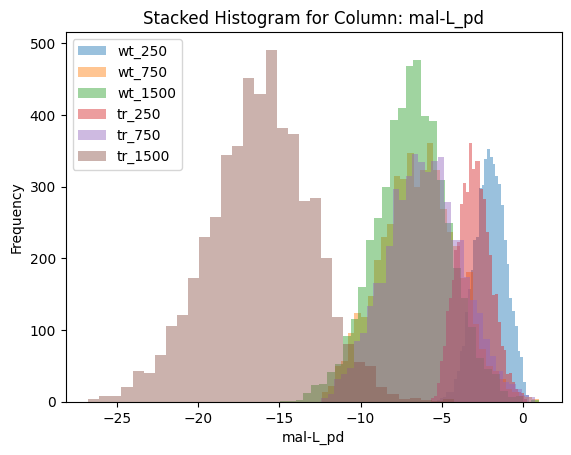

<Figure size 640x100 with 0 Axes>

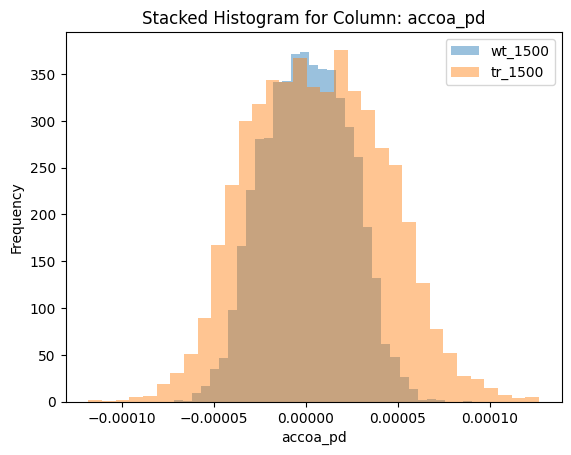

<Figure size 640x100 with 0 Axes>

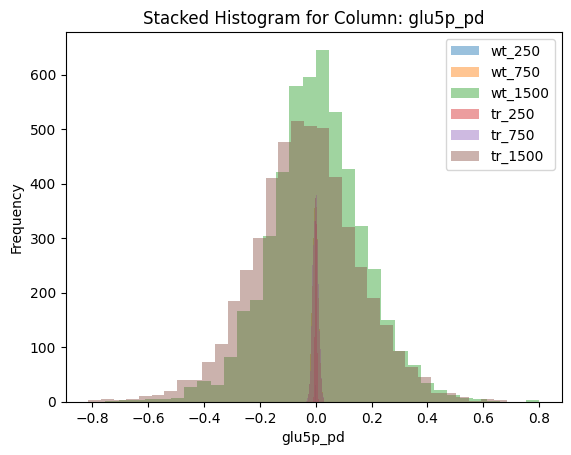

<Figure size 640x100 with 0 Axes>

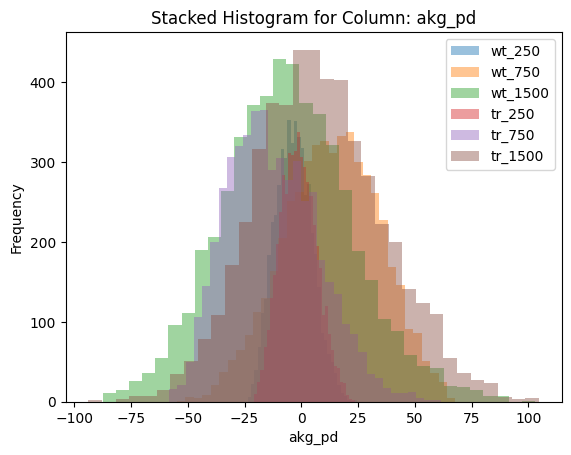

<Figure size 640x100 with 0 Axes>

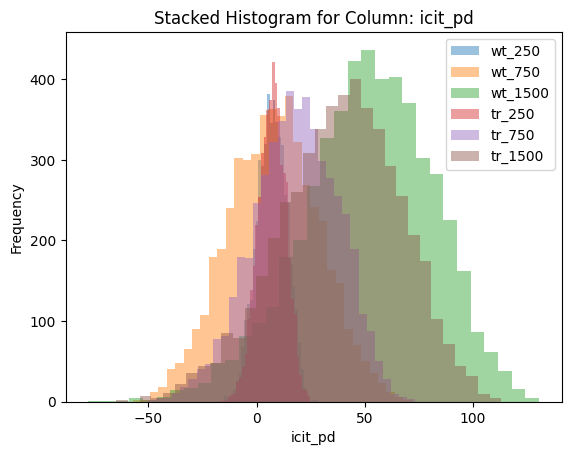

<Figure size 640x100 with 0 Axes>

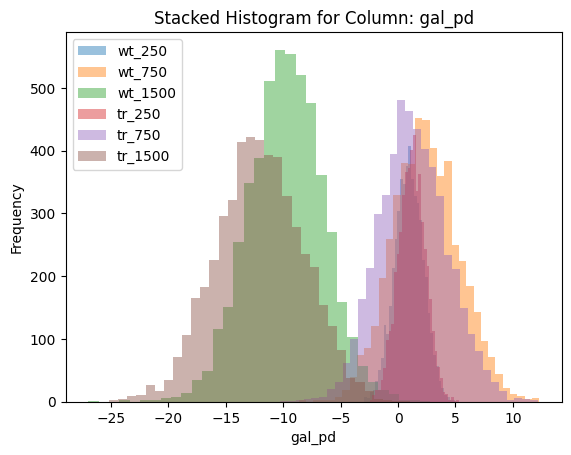

<Figure size 640x100 with 0 Axes>

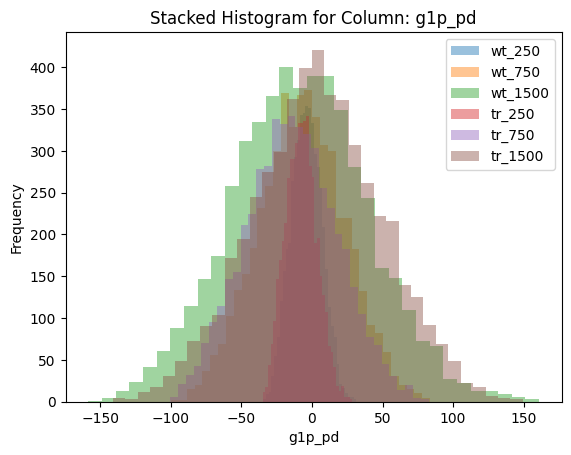

<Figure size 640x100 with 0 Axes>

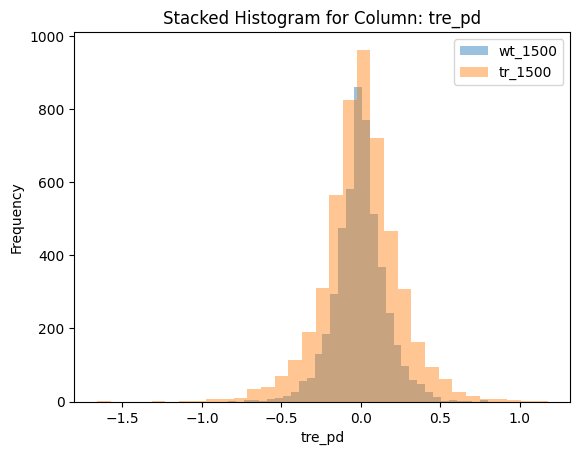

<Figure size 640x100 with 0 Axes>

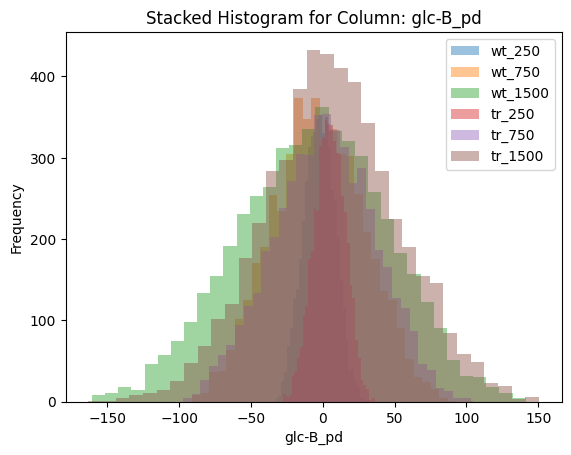

<Figure size 640x100 with 0 Axes>

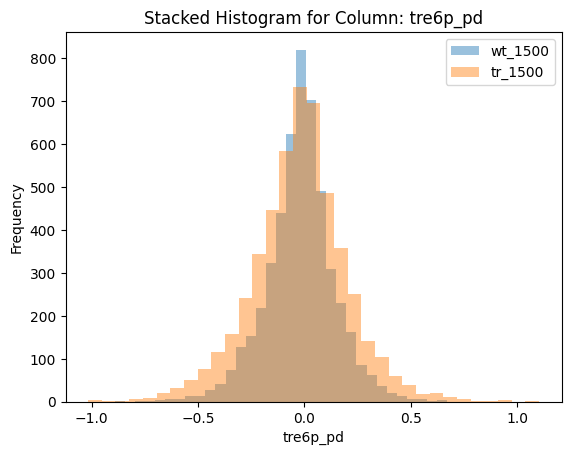

<Figure size 640x100 with 0 Axes>

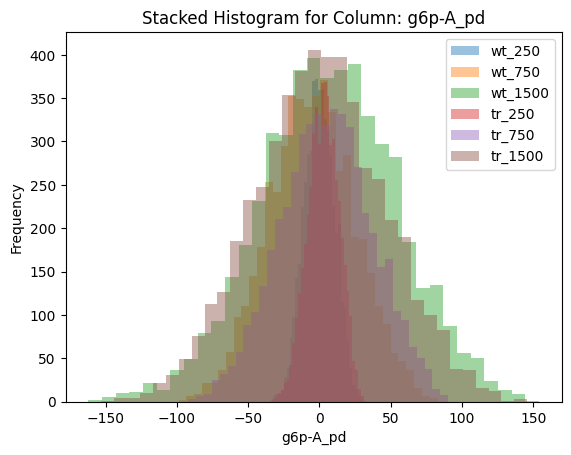

<Figure size 640x100 with 0 Axes>

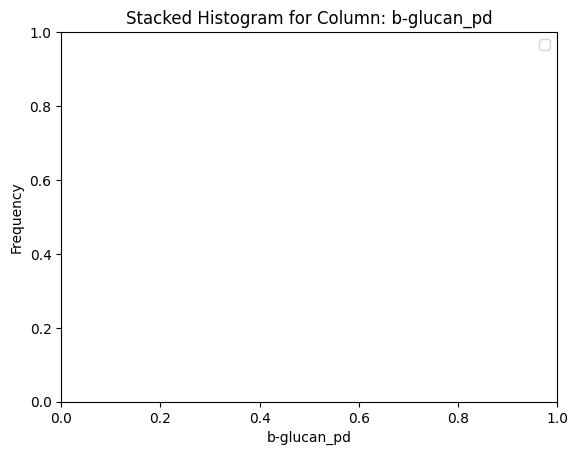

<Figure size 640x100 with 0 Axes>

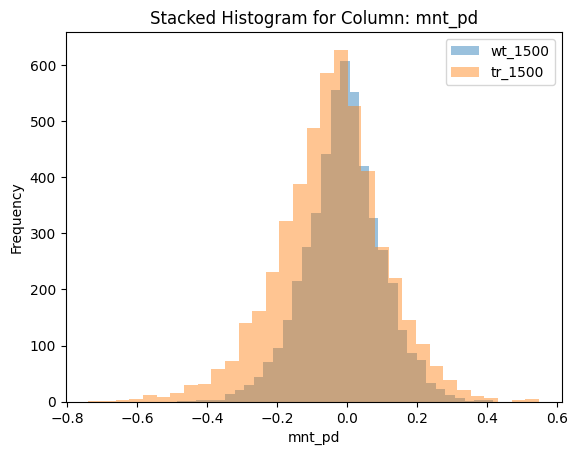

<Figure size 640x100 with 0 Axes>

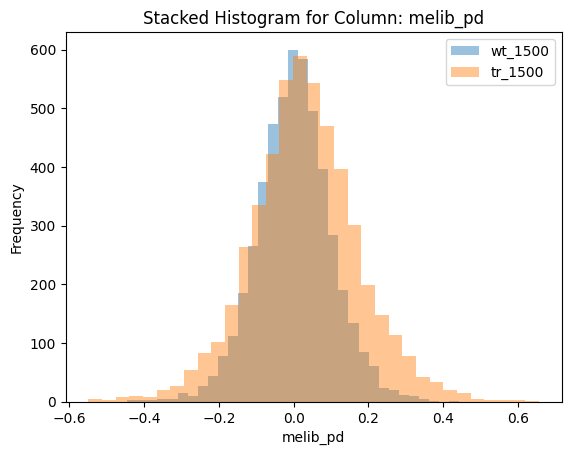

<Figure size 640x100 with 0 Axes>

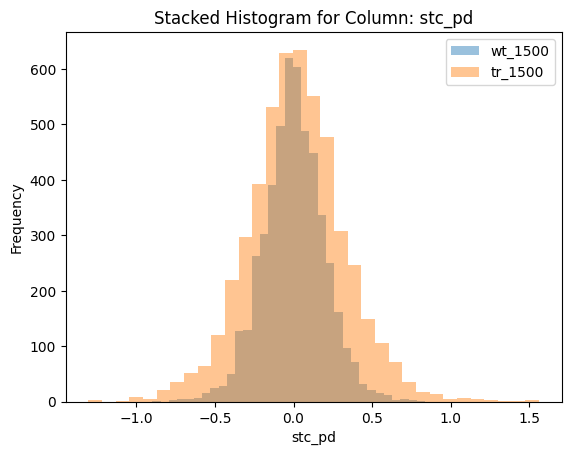

<Figure size 640x100 with 0 Axes>

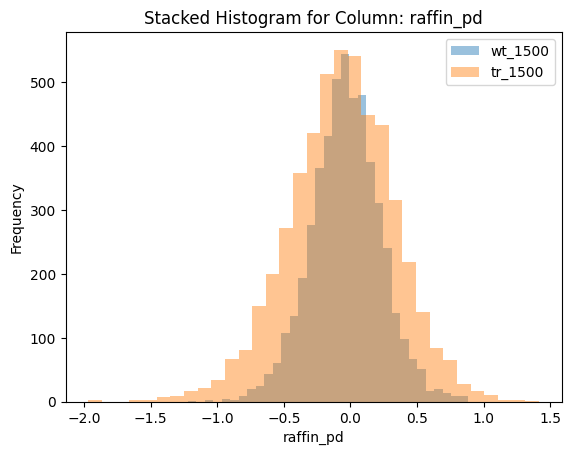

<Figure size 640x100 with 0 Axes>

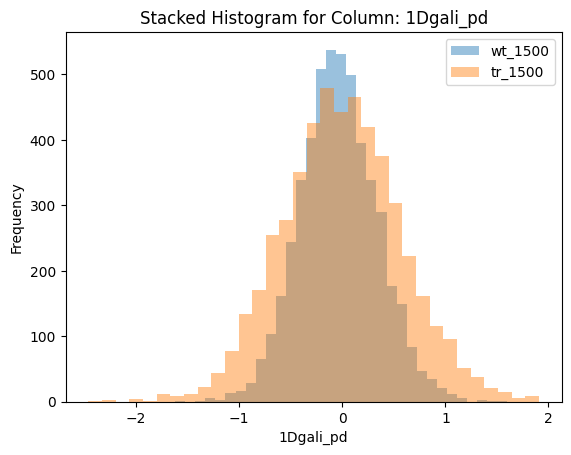

<Figure size 640x100 with 0 Axes>

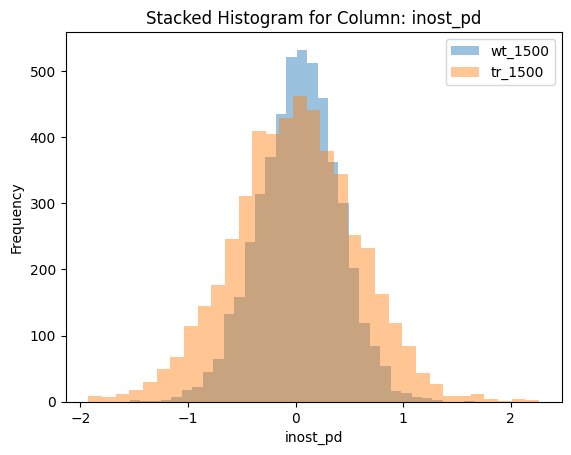

<Figure size 640x100 with 0 Axes>

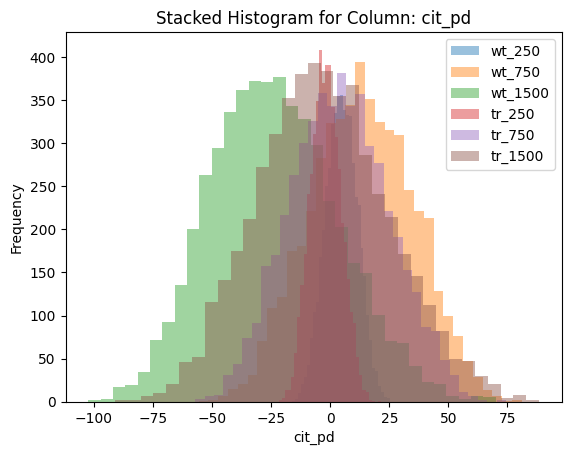

<Figure size 640x100 with 0 Axes>

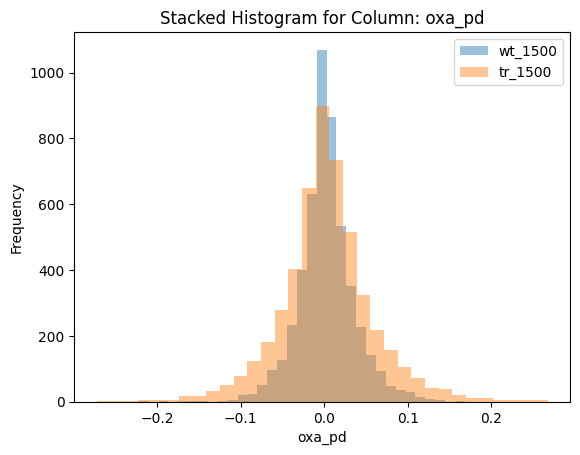

<Figure size 640x100 with 0 Axes>

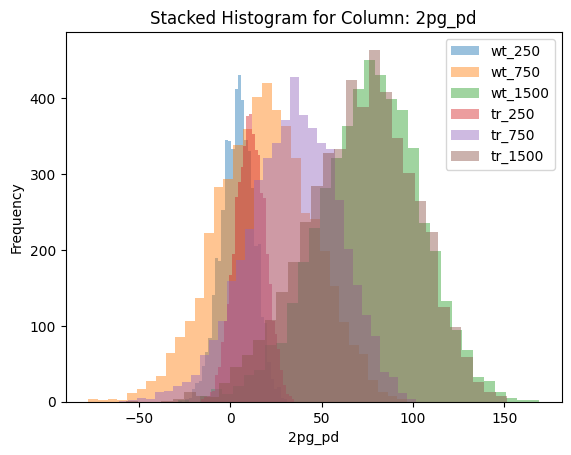

<Figure size 640x100 with 0 Axes>

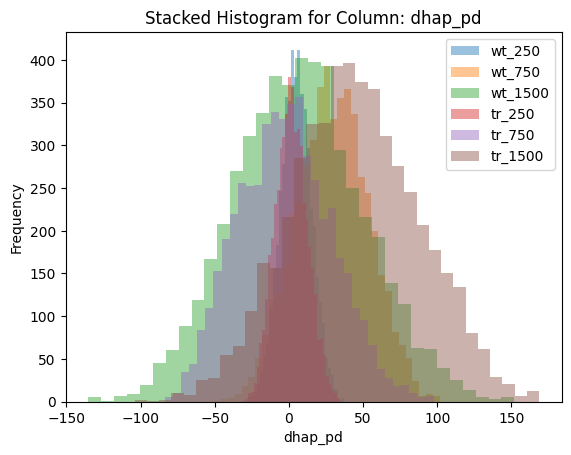

<Figure size 640x100 with 0 Axes>

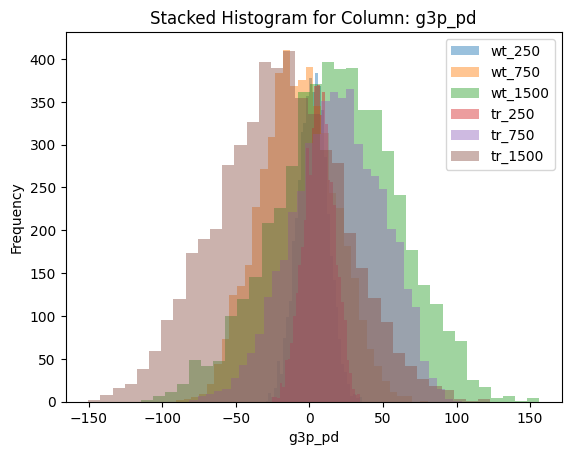

<Figure size 640x100 with 0 Axes>

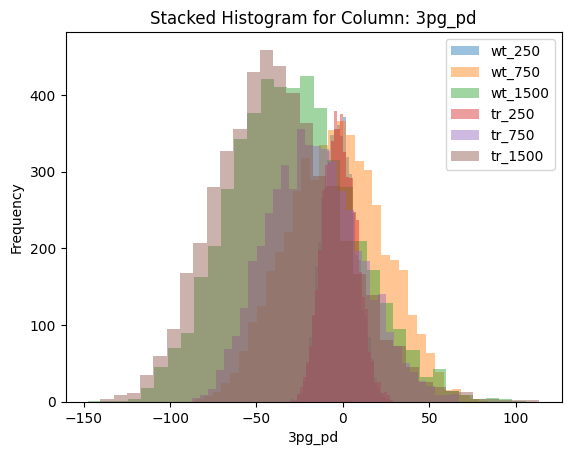

<Figure size 640x100 with 0 Axes>

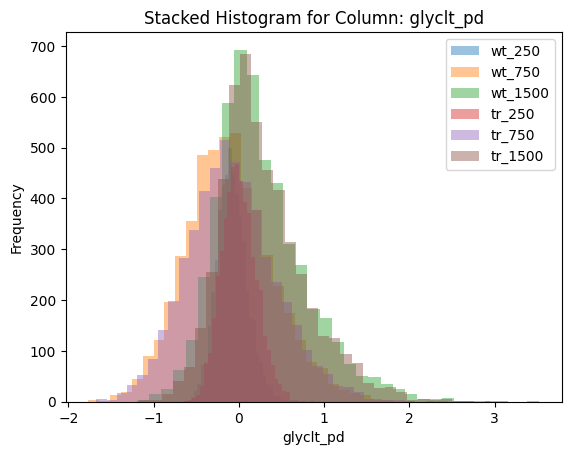

<Figure size 640x100 with 0 Axes>

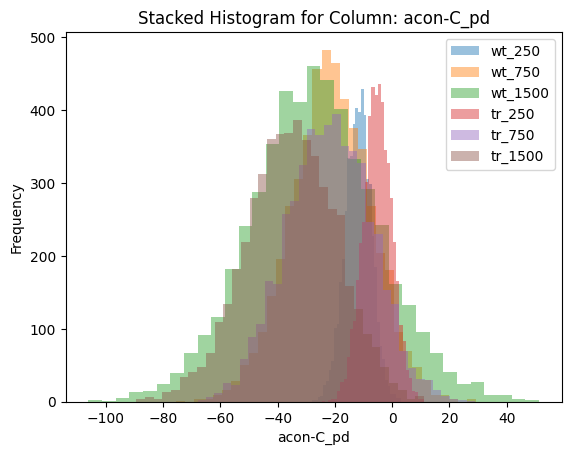

<Figure size 640x100 with 0 Axes>

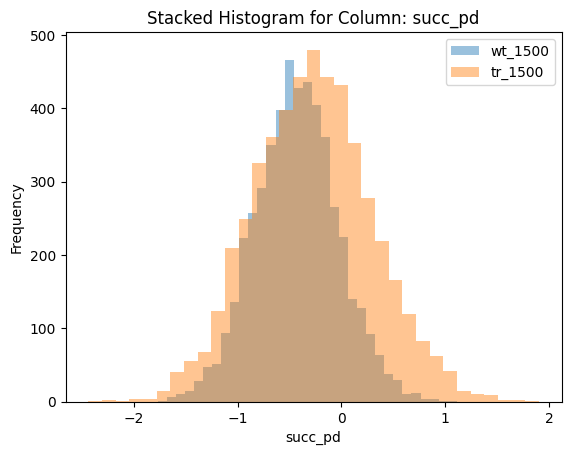

<Figure size 640x100 with 0 Axes>

In [36]:
pd_reactions = (rxns for rxns in wt_model.reactions if "_pd" in rxns.id)

for rxns in pd_reactions:
    generate_stacked_histogram(df_list, rxns.id)

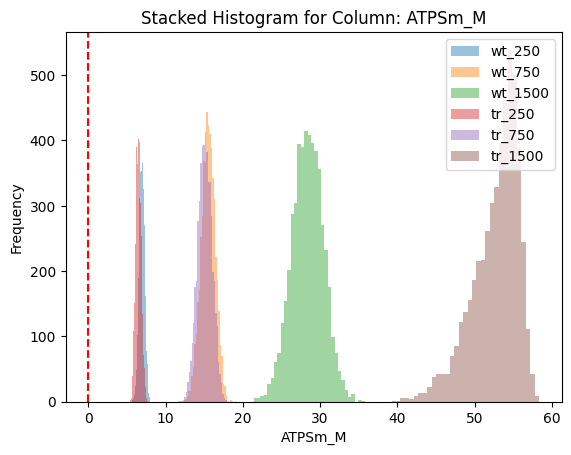

<Figure size 640x100 with 0 Axes>

In [61]:
generate_stacked_histogram(df_list, 'ATPSm_M')

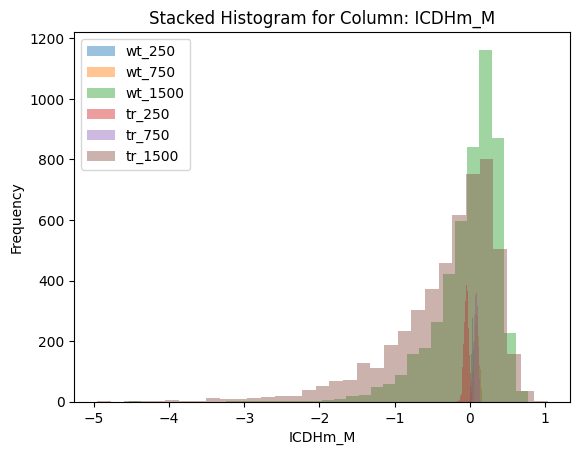

<Figure size 640x100 with 0 Axes>

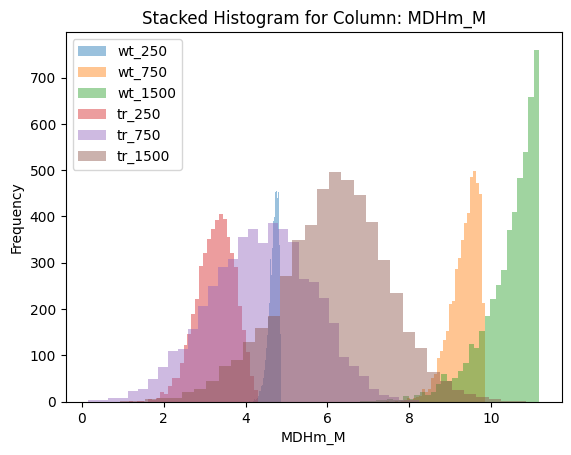

<Figure size 640x100 with 0 Axes>

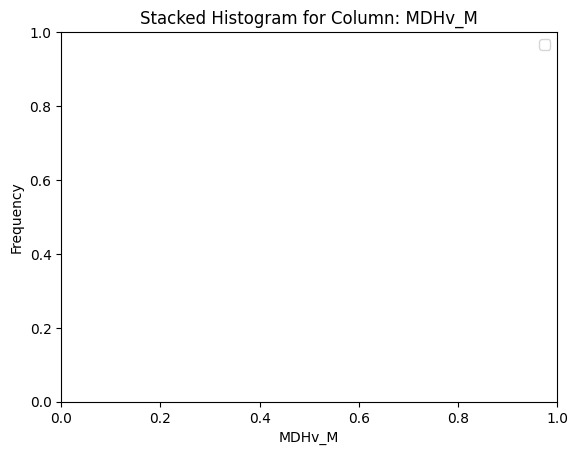

<Figure size 640x100 with 0 Axes>

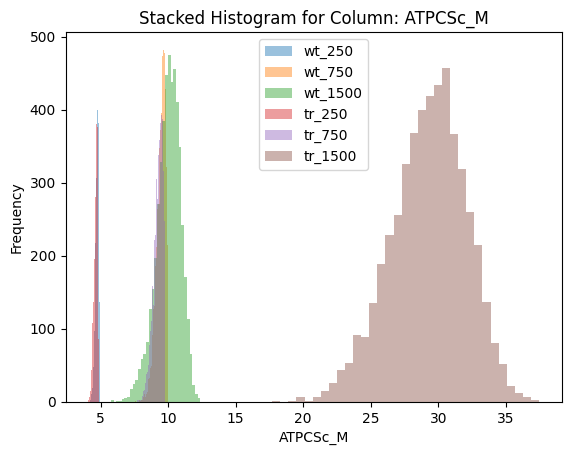

<Figure size 640x100 with 0 Axes>

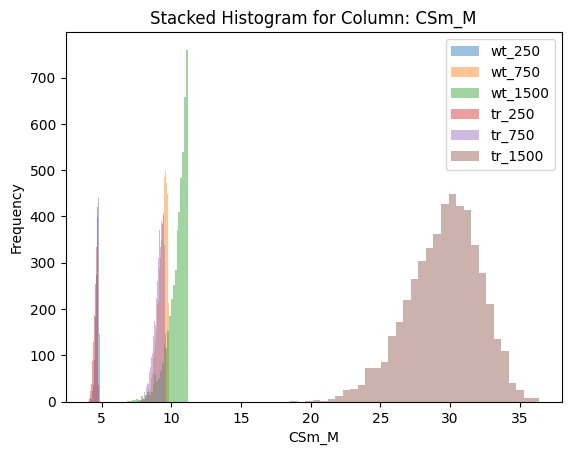

<Figure size 640x100 with 0 Axes>

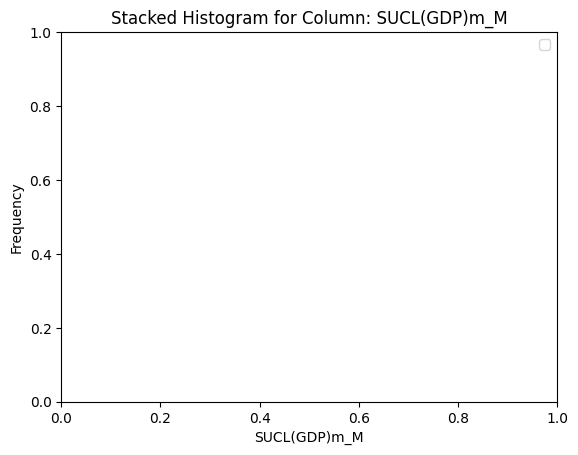

<Figure size 640x100 with 0 Axes>

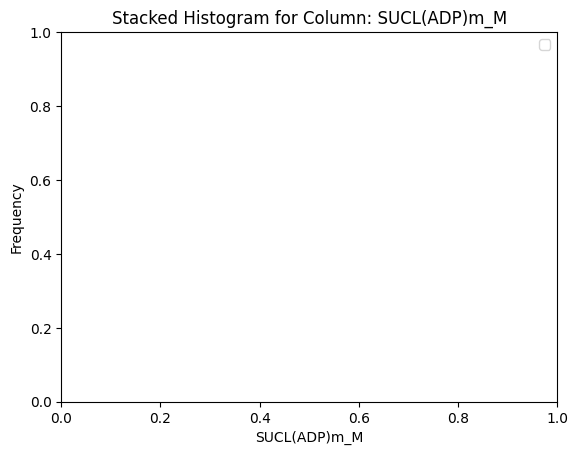

<Figure size 640x100 with 0 Axes>

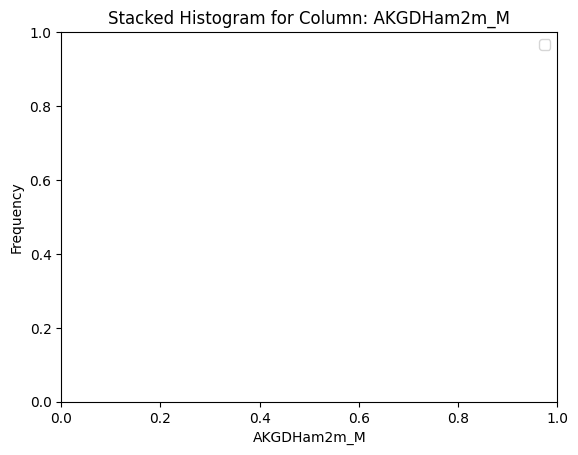

<Figure size 640x100 with 0 Axes>

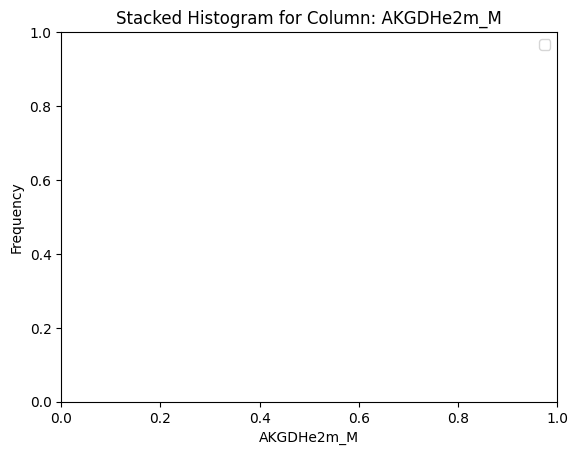

<Figure size 640x100 with 0 Axes>

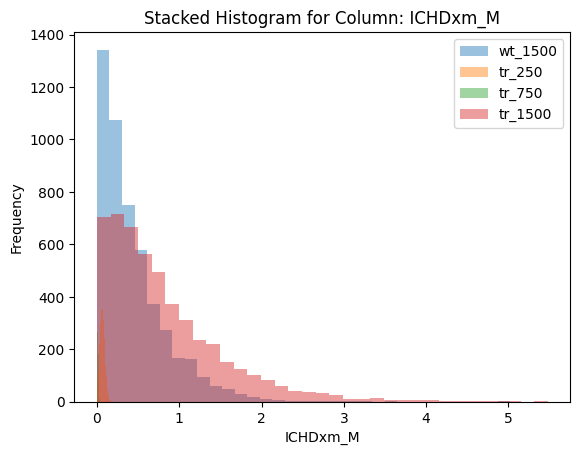

<Figure size 640x100 with 0 Axes>

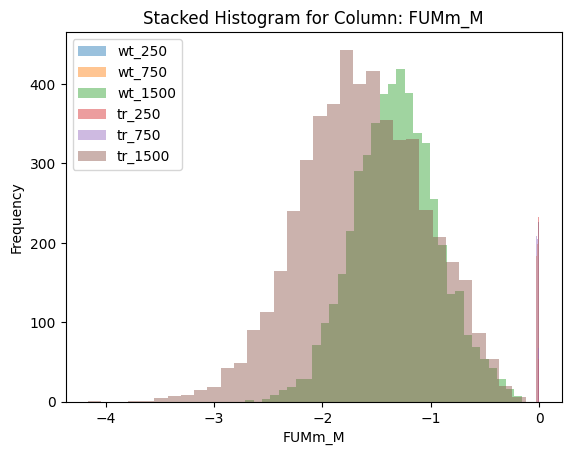

<Figure size 640x100 with 0 Axes>

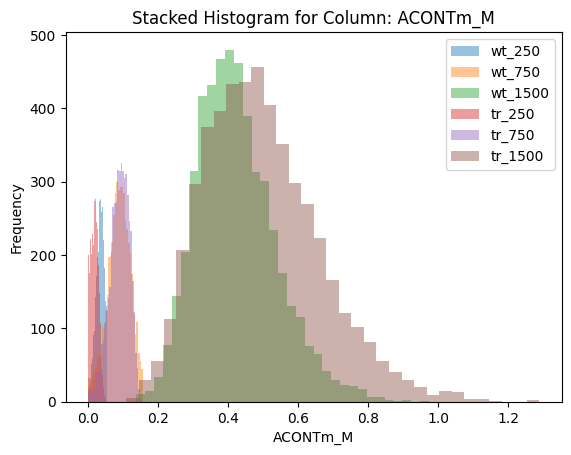

<Figure size 640x100 with 0 Axes>

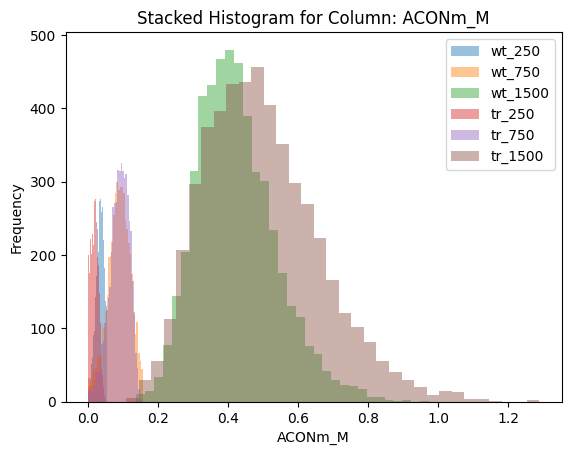

<Figure size 640x100 with 0 Axes>

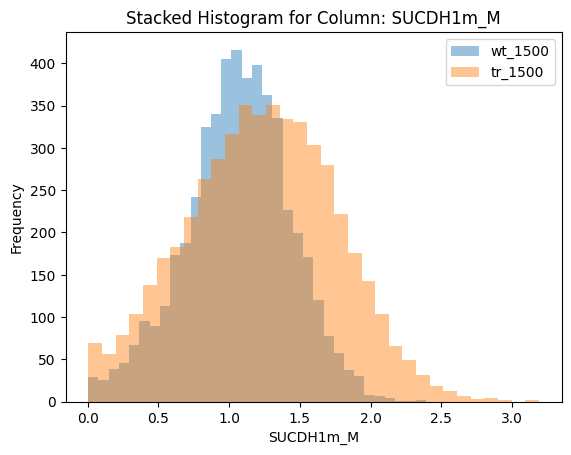

<Figure size 640x100 with 0 Axes>

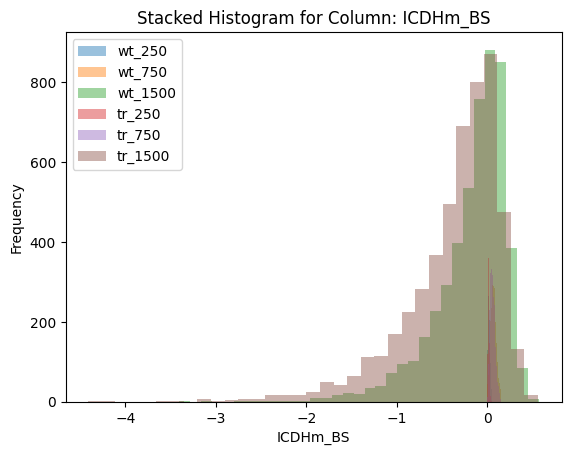

<Figure size 640x100 with 0 Axes>

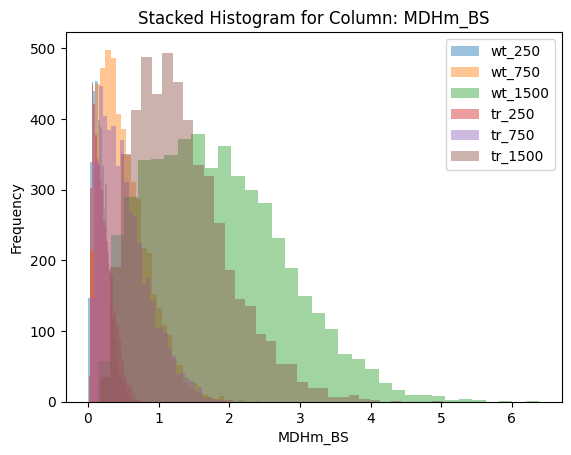

<Figure size 640x100 with 0 Axes>

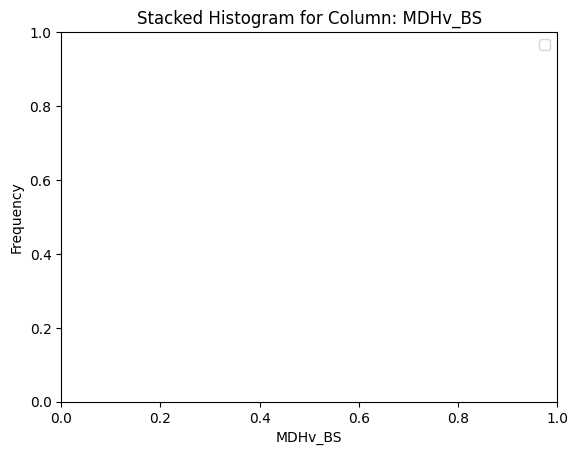

<Figure size 640x100 with 0 Axes>

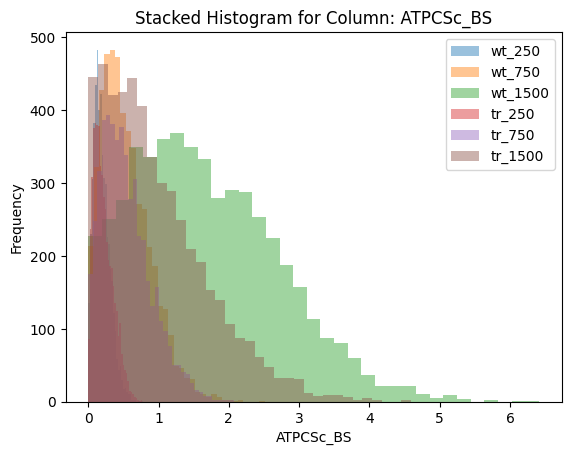

<Figure size 640x100 with 0 Axes>

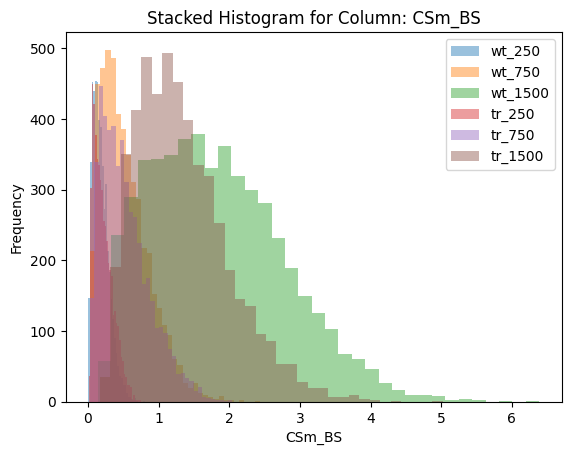

<Figure size 640x100 with 0 Axes>

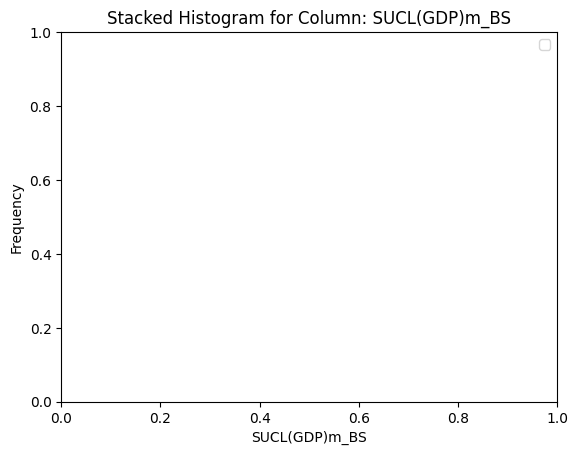

<Figure size 640x100 with 0 Axes>

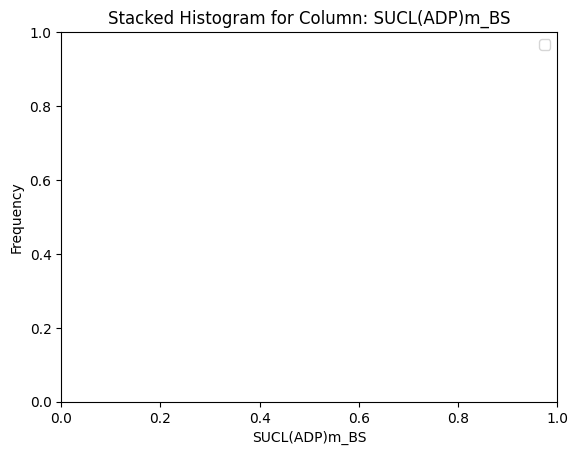

<Figure size 640x100 with 0 Axes>

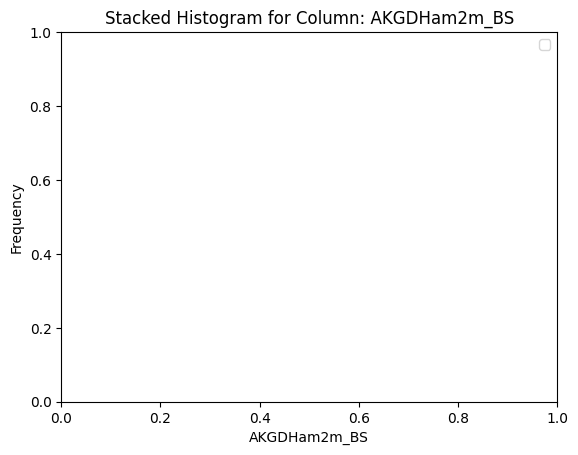

<Figure size 640x100 with 0 Axes>

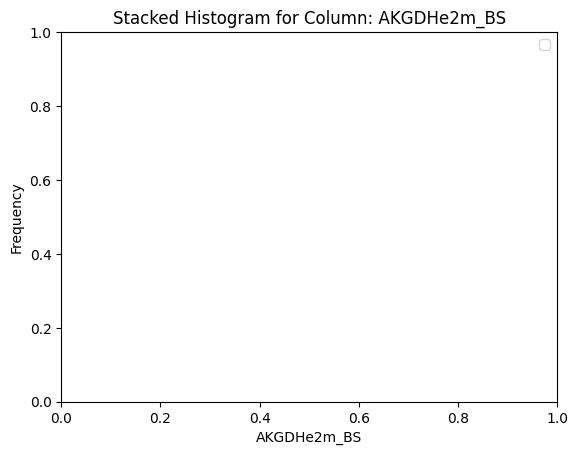

<Figure size 640x100 with 0 Axes>

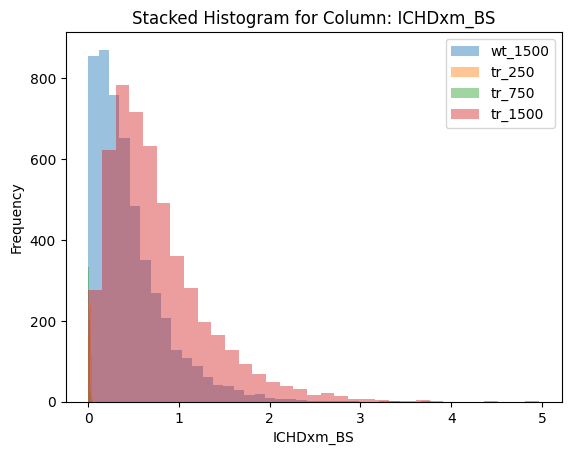

<Figure size 640x100 with 0 Axes>

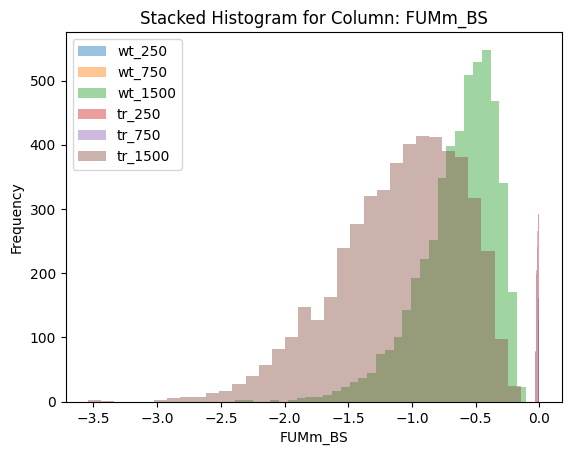

<Figure size 640x100 with 0 Axes>

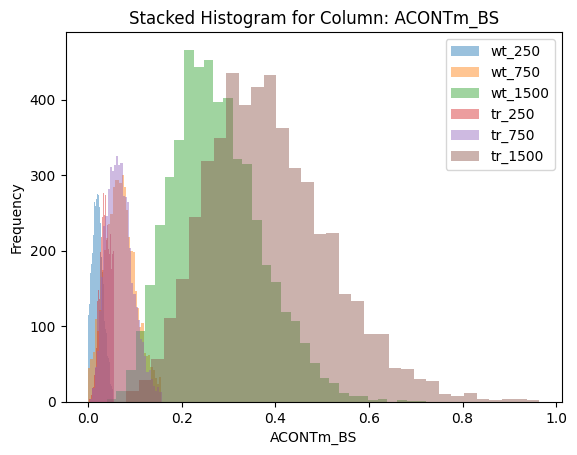

<Figure size 640x100 with 0 Axes>

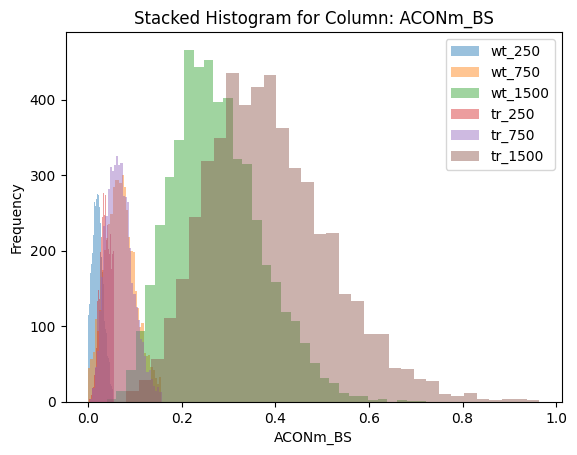

<Figure size 640x100 with 0 Axes>

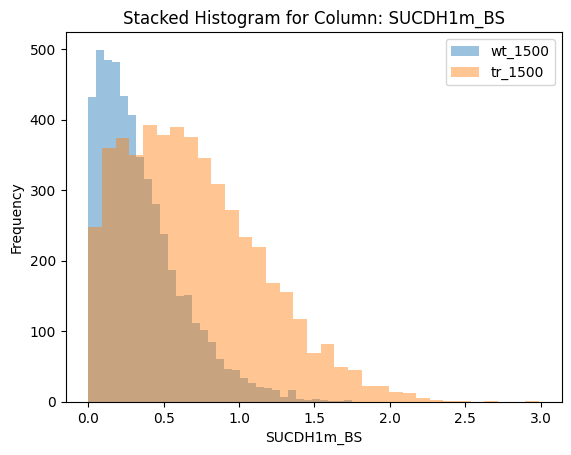

<Figure size 640x100 with 0 Axes>

In [13]:
#Generate histograms for TCA cycle reactions
TCA_rxns = list()

for rxn in wt_model.reactions:
    if rxn.notes and 'SUBSYSTEM' in rxn.notes:
        subsys = rxn.notes['SUBSYSTEM']
        if subsys == 'TCA Cycle':
            TCA_rxns.append(rxn)

for rxns in TCA_rxns:
    generate_stacked_histogram(df_list, rxns.id)

3. Check reactions involved with Malate in Cytosol

In [50]:
wt_model.metabolites.rb15bp_s0

<Metabolite rb15bp_s0 at 0x7f079c719ae0>

In [ ]:
generate_stacked_histogram(df_list, '')

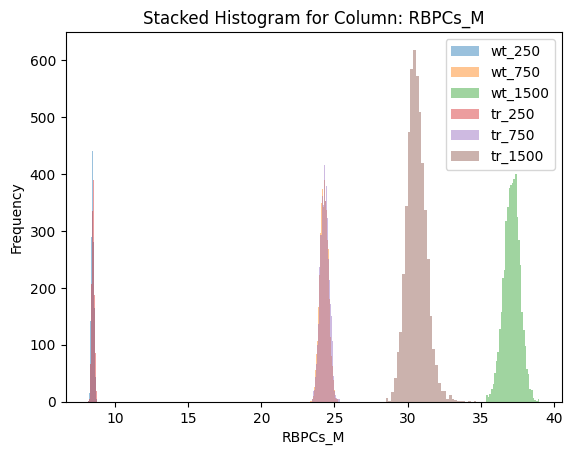

<Figure size 640x100 with 0 Axes>

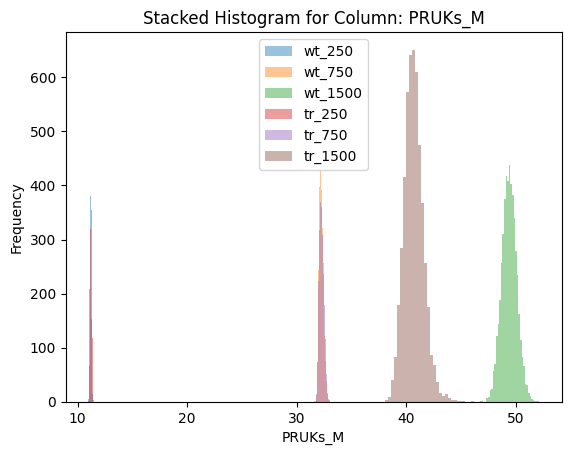

<Figure size 640x100 with 0 Axes>

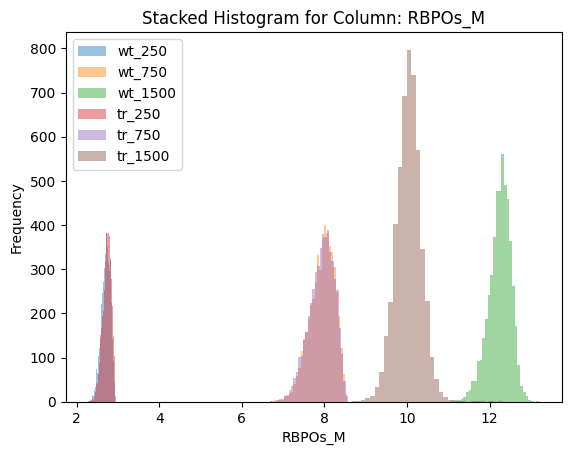

<Figure size 640x100 with 0 Axes>

In [51]:
#Reactions involving AKG
for met in wt_model.metabolites.get_by_id('rb15bp_s0').reactions:
    rxn_id = met.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)


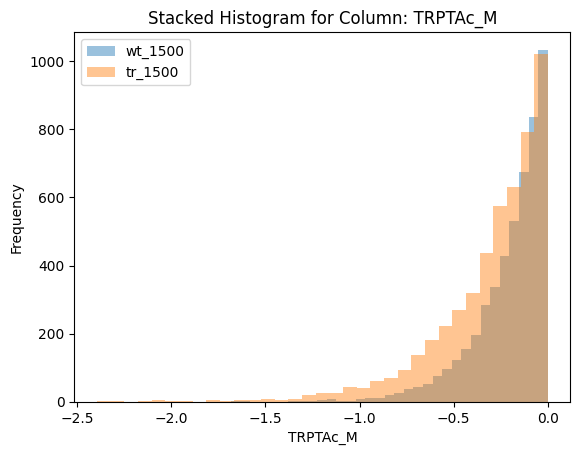

<Figure size 640x100 with 0 Axes>

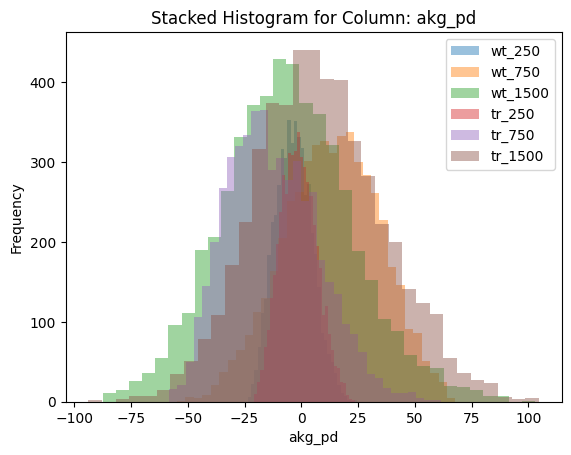

<Figure size 640x100 with 0 Axes>

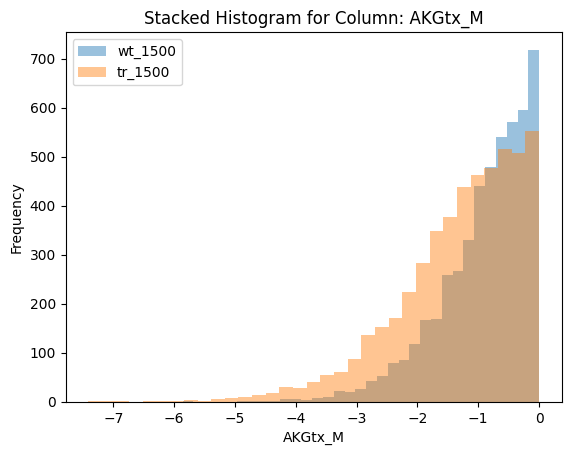

<Figure size 640x100 with 0 Axes>

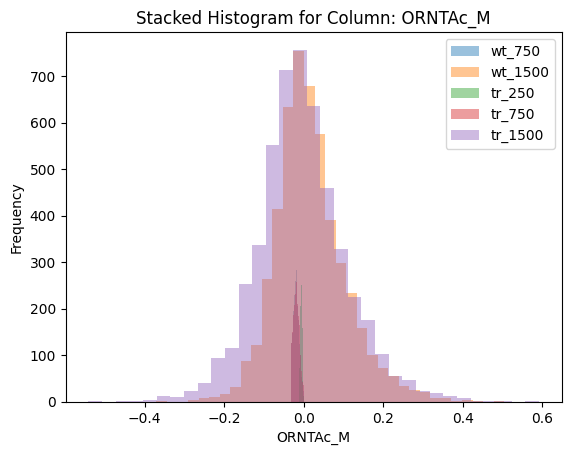

<Figure size 640x100 with 0 Axes>

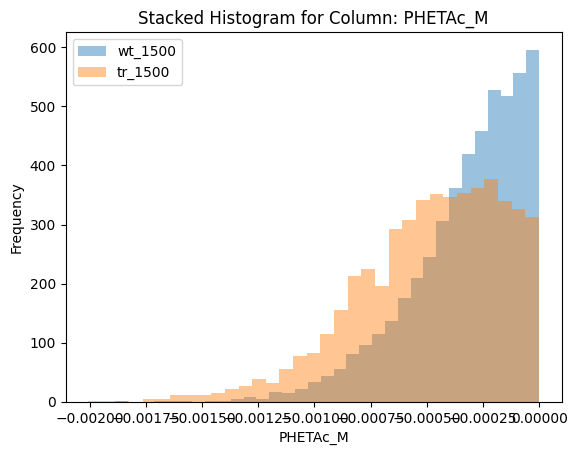

<Figure size 640x100 with 0 Axes>

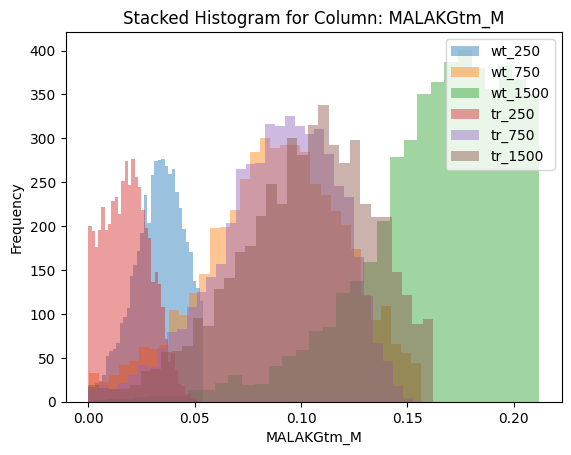

<Figure size 640x100 with 0 Axes>

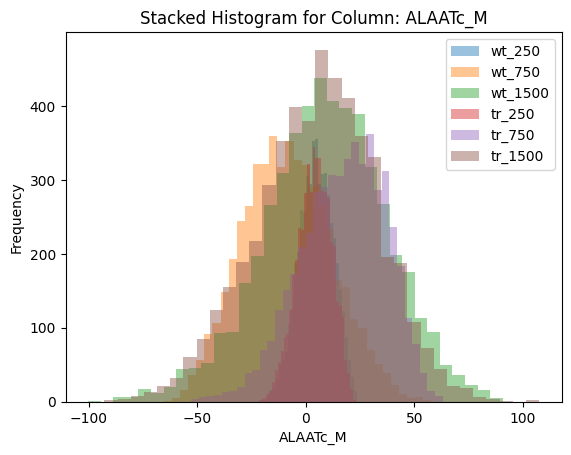

<Figure size 640x100 with 0 Axes>

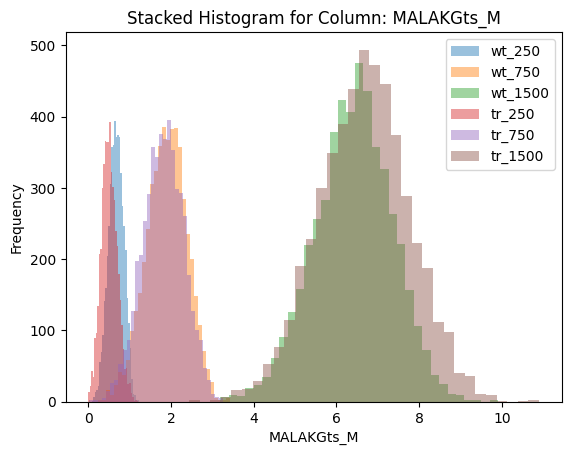

<Figure size 640x100 with 0 Axes>

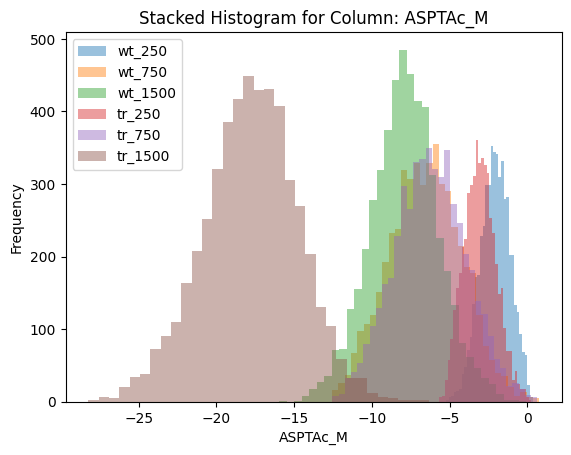

<Figure size 640x100 with 0 Axes>

In [19]:
#Reactions involving AKG
for akg in wt_model.metabolites.get_by_id('akg_c0').reactions:
    rxn_id = akg.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)


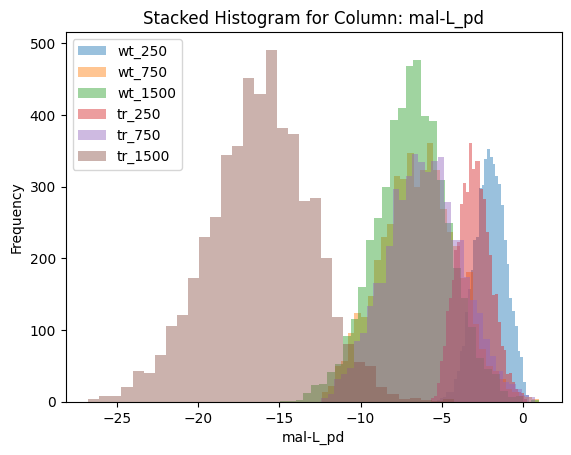

<Figure size 640x100 with 0 Axes>

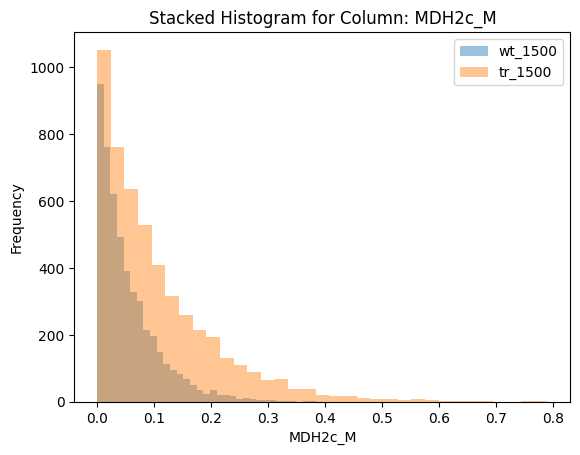

<Figure size 640x100 with 0 Axes>

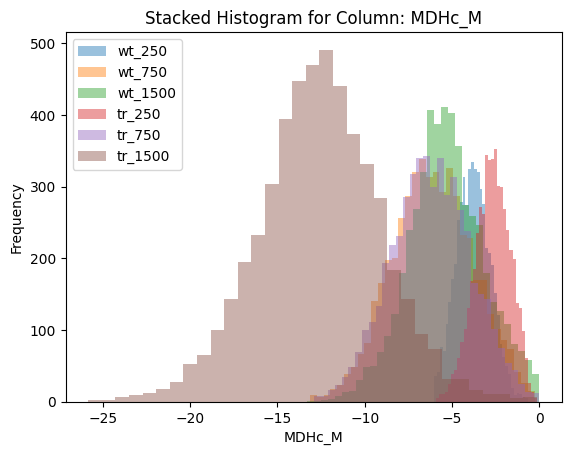

<Figure size 640x100 with 0 Axes>

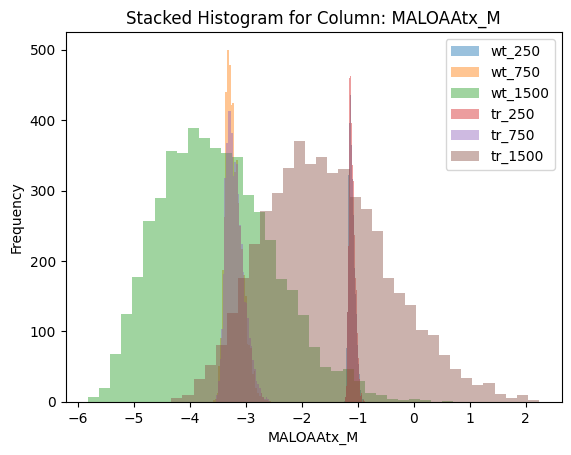

<Figure size 640x100 with 0 Axes>

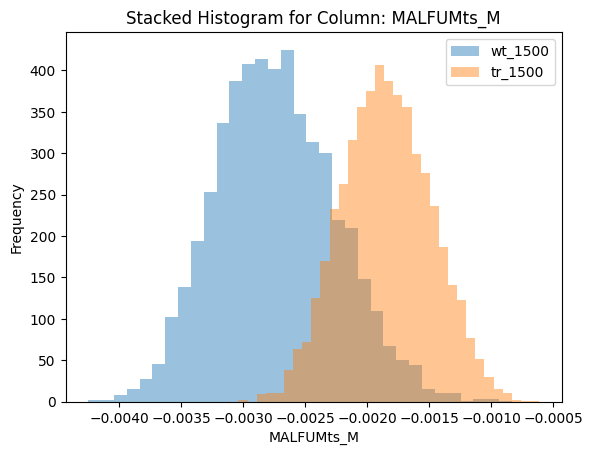

<Figure size 640x100 with 0 Axes>

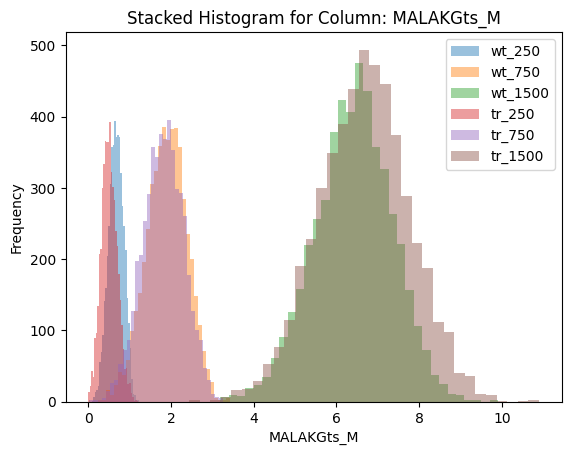

<Figure size 640x100 with 0 Axes>

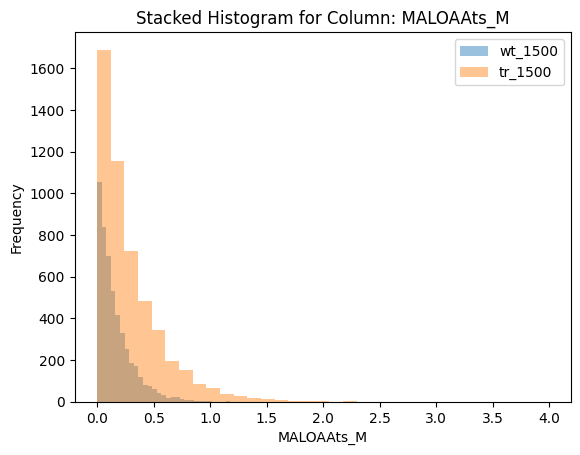

<Figure size 640x100 with 0 Axes>

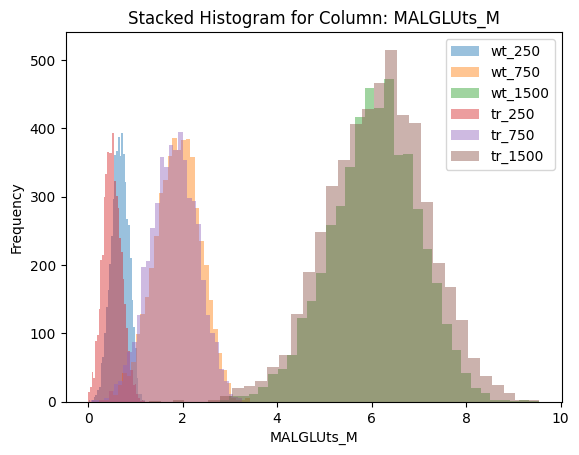

<Figure size 640x100 with 0 Axes>

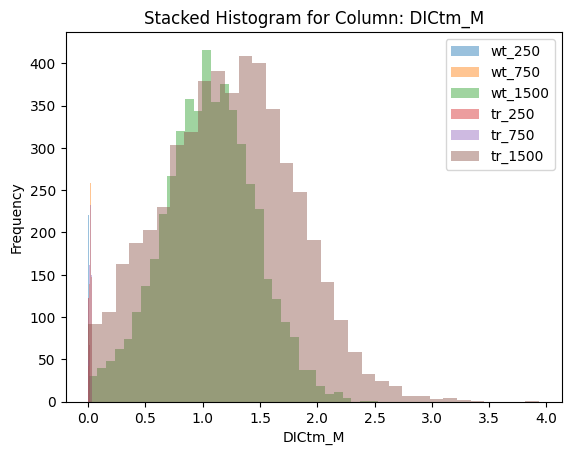

<Figure size 640x100 with 0 Axes>

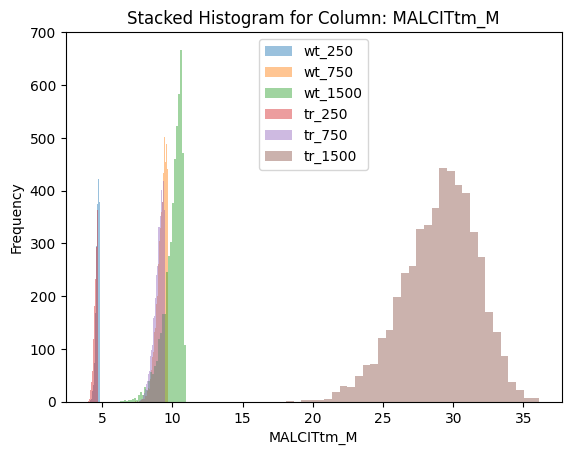

<Figure size 640x100 with 0 Axes>

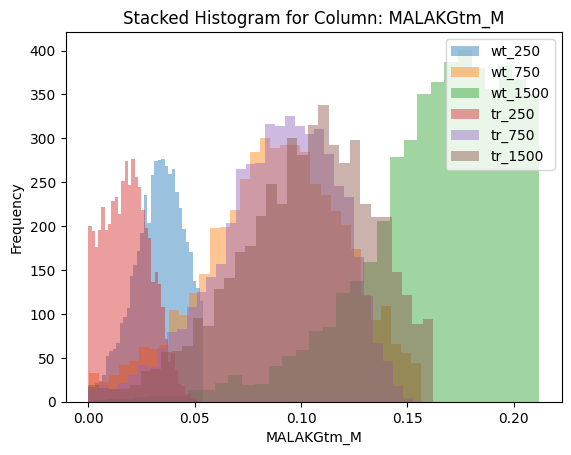

<Figure size 640x100 with 0 Axes>

In [21]:


#Reactions involving Malate in the Mitochondria M cell
for malate in wt_model.metabolites.get_by_id('mal-L_c0').reactions:
    rxn_id = malate.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)


In [63]:
wt_model.reactions.MDHs_M

<Reaction MDHs_M at 0x7f079bd2dde0>

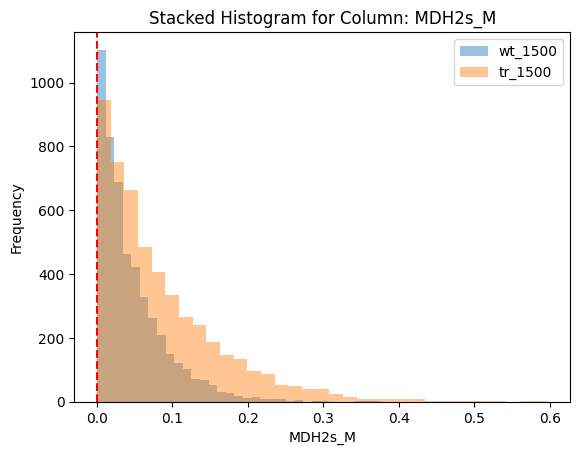

<Figure size 640x100 with 0 Axes>

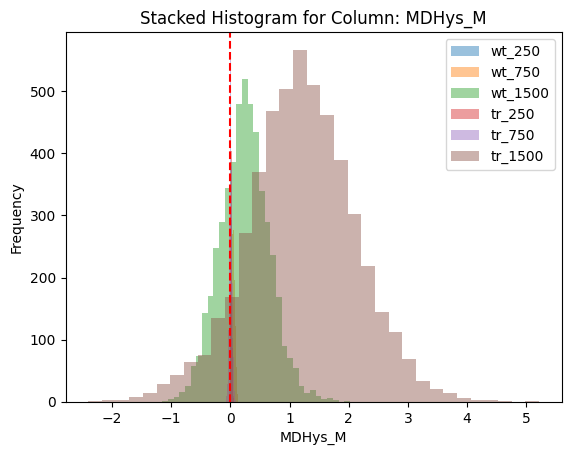

<Figure size 640x100 with 0 Axes>

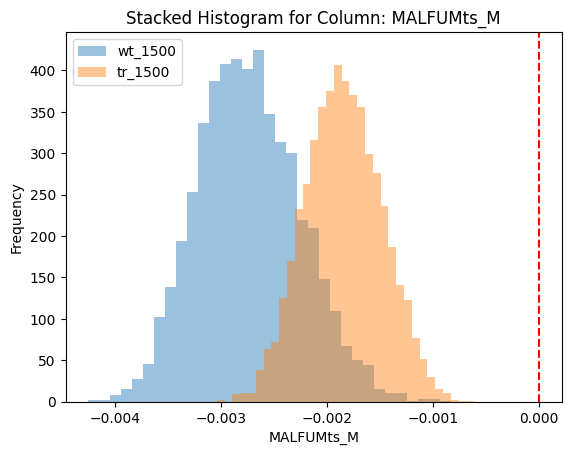

<Figure size 640x100 with 0 Axes>

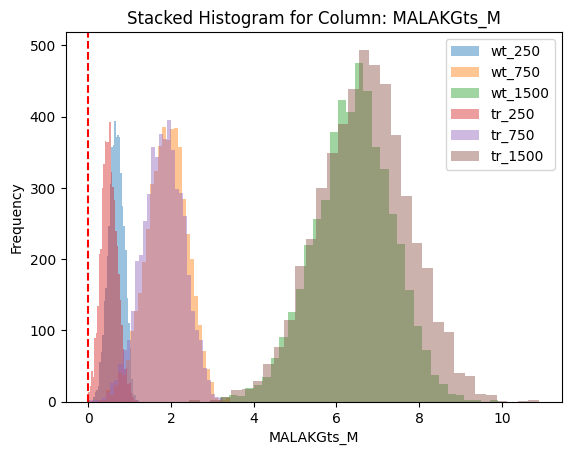

<Figure size 640x100 with 0 Axes>

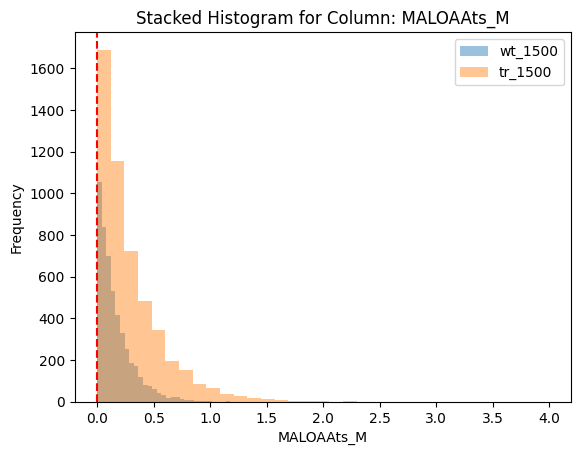

<Figure size 640x100 with 0 Axes>

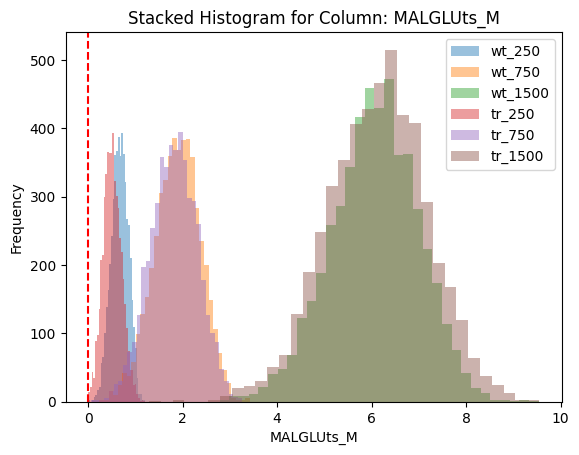

<Figure size 640x100 with 0 Axes>

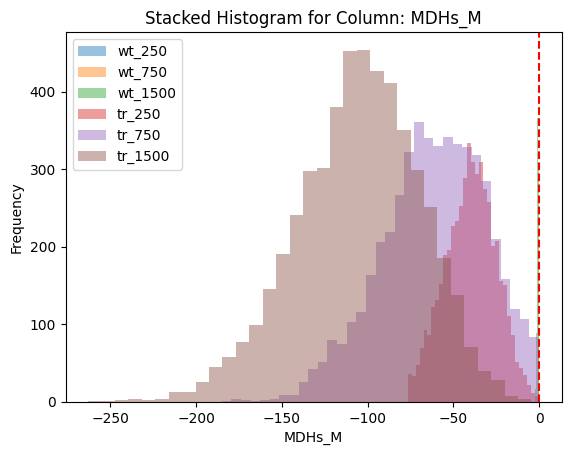

<Figure size 640x100 with 0 Axes>

In [62]:
#Check Malate related reactions in the Chloroplast



#Reactions involving Malate in the stromal M cell
for malate in wt_model.metabolites.get_by_id('mal-L_s0').reactions:
    rxn_id = malate.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)
        
#Malate is generated mainly by MDHs in the stroma. THe question is wehre is the OAA coming from?


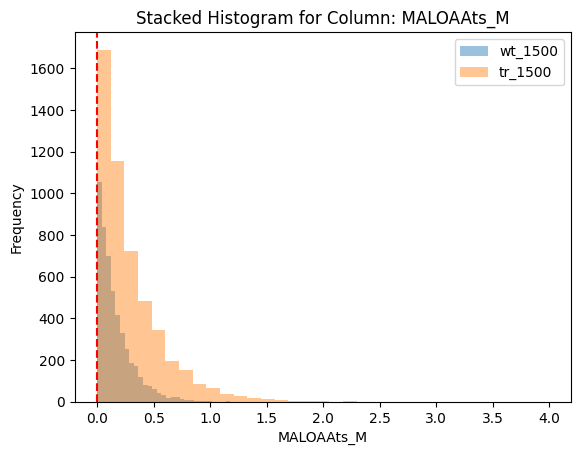

<Figure size 640x100 with 0 Axes>

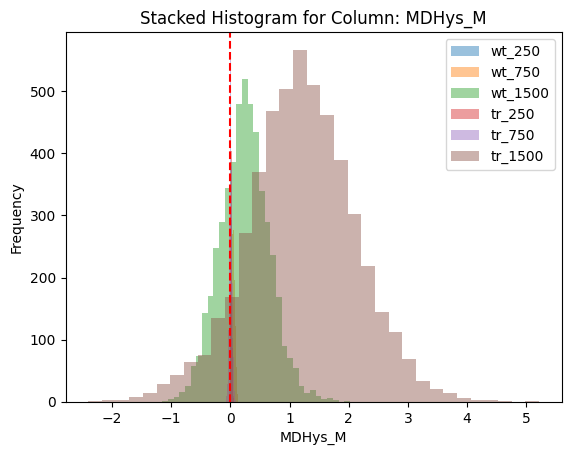

<Figure size 640x100 with 0 Axes>

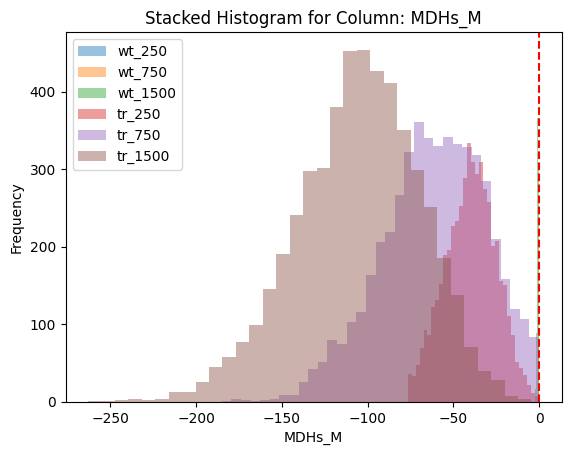

<Figure size 640x100 with 0 Axes>

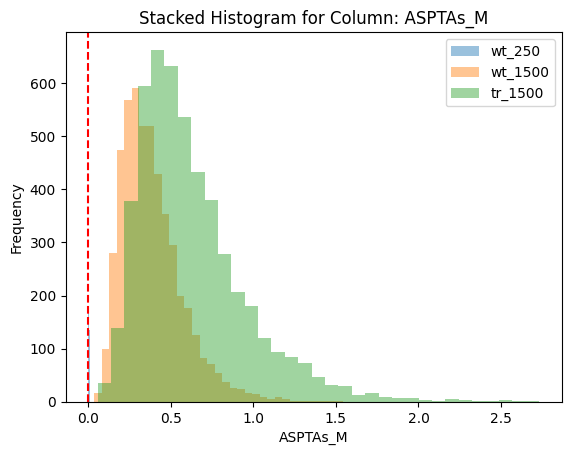

<Figure size 640x100 with 0 Axes>

In [68]:
#Check Malate related reactions in the Chloroplast



#Reactions involving OAA in the stromal M cell
for oaa in wt_model.metabolites.get_by_id('oaa_s0').reactions:
    rxn_id = oaa.id
    check = check_column_exists(df_list, rxn_id)
    if check == True:
        generate_stacked_histogram(df_list, rxn_id)
        
#Malate is generated mainly by MDHs in the stroma. THe question is wehre is the OAA coming from?


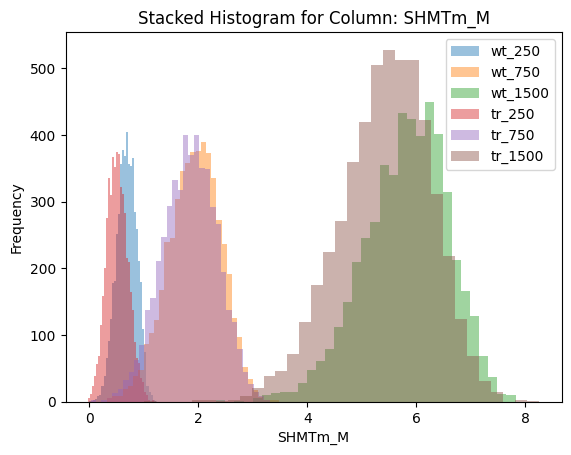

<Figure size 640x100 with 0 Axes>

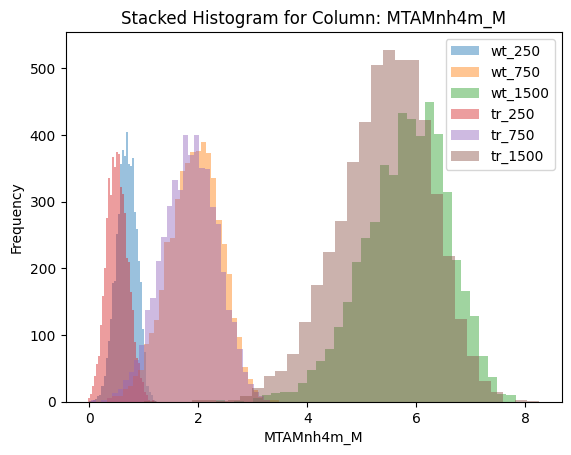

<Figure size 640x100 with 0 Axes>

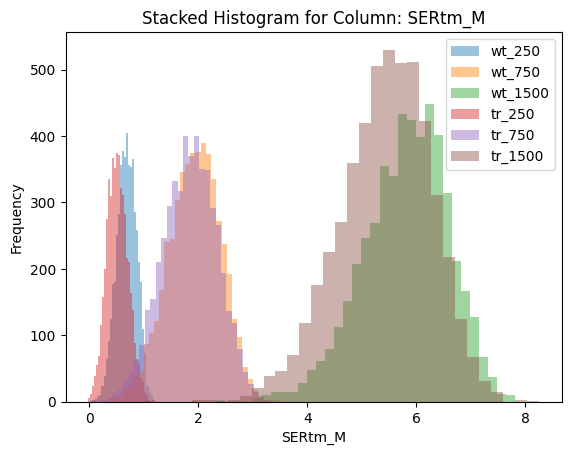

<Figure size 640x100 with 0 Axes>

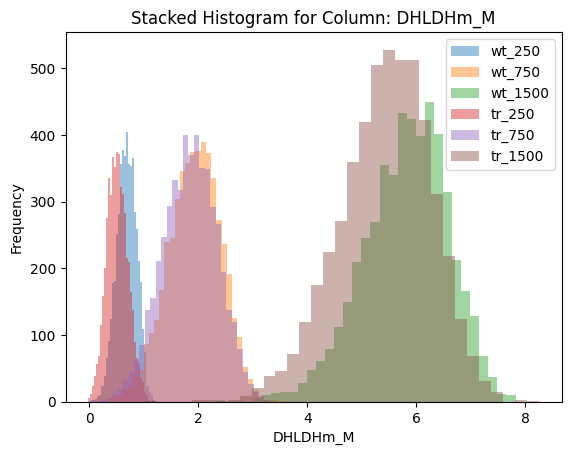

<Figure size 640x100 with 0 Axes>

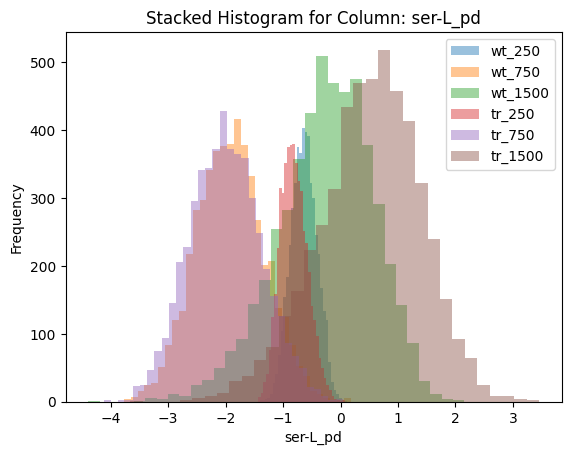

<Figure size 640x100 with 0 Axes>

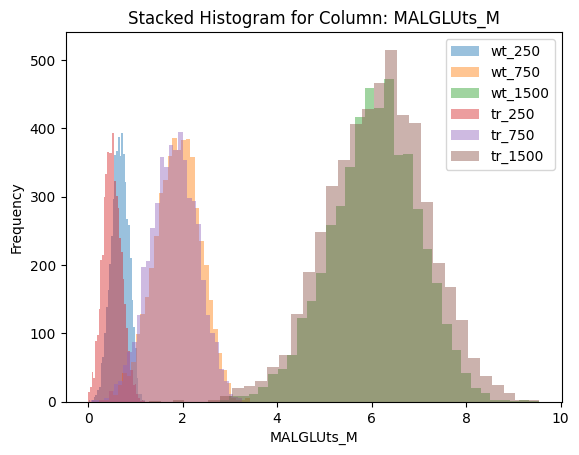

<Figure size 640x100 with 0 Axes>

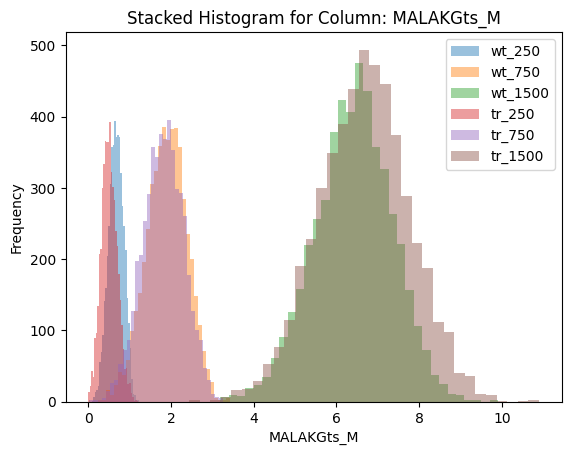

<Figure size 640x100 with 0 Axes>

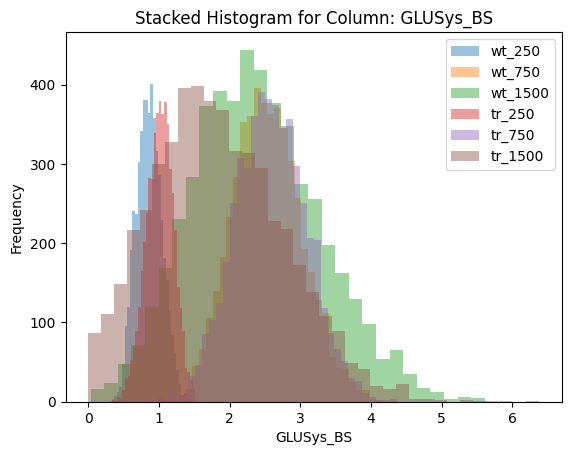

<Figure size 640x100 with 0 Axes>

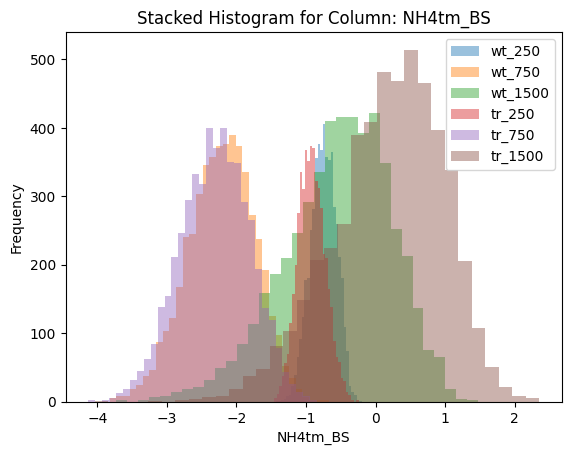

<Figure size 640x100 with 0 Axes>

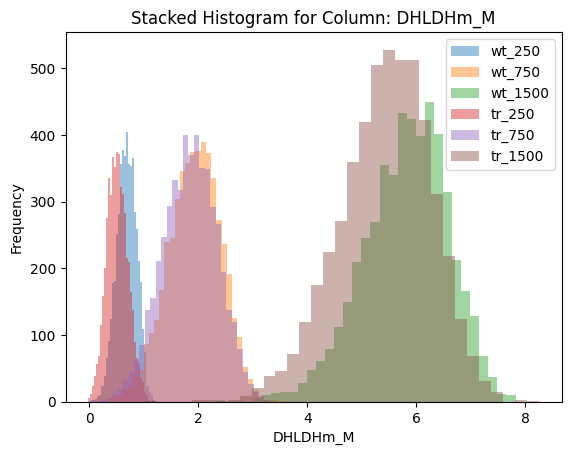

<Figure size 640x100 with 0 Axes>

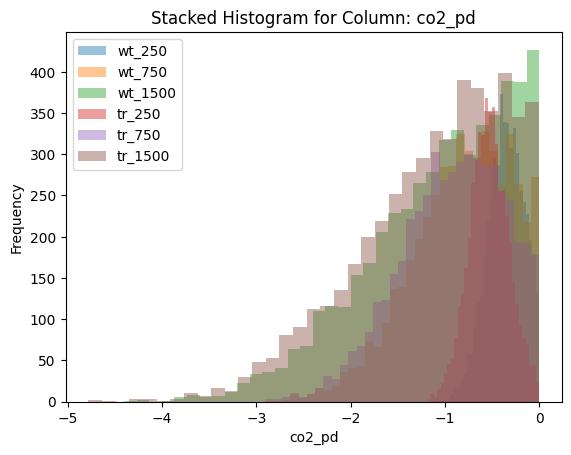

<Figure size 640x100 with 0 Axes>

In [26]:
#This is for Glycine Decarboxylase in the Bundle sheath cell. Behavior is firmly forward towards decarboxylation at low to  intermediate light levels before
#Settling near 0 to carboxylation @ high light levels, indicating that the reaction trends toward equilibrium at high light levels.

generate_stacked_histogram(df_list, 'SHMTm_M')

generate_stacked_histogram(df_list, 'MTAMnh4m_M')

generate_stacked_histogram(df_list, 'SERtm_M')
generate_stacked_histogram(df_list, 'DHLDHm_M')

generate_stacked_histogram(df_list, 'ser-L_pd')
generate_stacked_histogram(df_list, 'MALGLUts_M')
generate_stacked_histogram(df_list, 'MALAKGts_M')

generate_stacked_histogram(df_list, 'GLUSys_BS')
generate_stacked_histogram(df_list, 'NH4tm_BS')

generate_stacked_histogram(df_list,'DHLDHm_M')

generate_stacked_histogram(df_list,'co2_pd')




#Histogram for GLycine decarboxylase (First committal step to the C2 shuttle in plants -- GLycine shunt)
#Interestingly, the fluxes become more decoupled at higher  light regimens in the Trans-parametrized plants, possibly reducing photorespiration at this level?


Analysis of Rubisco Activity in BS and M Cells

Interestingly, it predicts a maximal reaction flux @ medium light levels @ 750 PPFD while showing a slightly higher reaction rates at low light levels, but only with minimal flux. Why kaya

RESULTS:

1. Interestingly, it was found out that across all light conditions, the BS RBCL features highest flux ranges at medium light ranges (750 PPFD) than either in low or high light conditions. This relationship holds true for both Wild-type and Trans-parametrized models. 

2. Due to the carbon assimilation constraints, Rubisco becomes strongly decoupled at high light levels while featuring similar distributions at low and medium light parametrizations. However, it is also  detected to have a significantly different flux distributions when taking into account the results from the Kruskal-Wallis Test.

3. The list of decoupled reactions and their percentage based on the total active fluxes are as follows:







STAT NO. 3: FLUX COUPLING ANALYSIS

This is a technique that is used to detect couplings between specific reactions in a given model. This technique is elaborated upon by Price, SChellenberger & Palsson (2004) in which a randomly sampled solution space, appropriately constrained based on environmental and phenotypic conditions, allows us to infer pairwise relations between the flux solutions. In turn, this method allows us to see which reactions are strongly coupled with each other given a set of constraints. 

Here are some reactions that I am particularly interested in, since I've found that they were unexpectedly decoupled from each other:
-PSIINC_M
-RBPCs_BS


Correlation of flux measurements: use in designing experiments
Uniform random sampling of the steady-state flux space allows for the calculation of the correlation coefficient (rij) between any two fluxes (vi and vj) in the network. Thus, sampling provides a straightforward means of not only calculating perfectly correlated subsets (
), but also of identifying well-correlated, but not perfectly correlated reaction sets. The matrix of squared pairwise correlation coefficients for all the RBC metabolic fluxes was computed. The fluxes can be ordered such that the “correlated reaction sets” (defined here as 
) are listed in order of decreasing number of fluxes in each set (Table 1).


From Price, Schellenberger and Palsson, (2004) -- Uniform Sammpling of flux





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.
